# Import bibliotek

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'C:\\Users\\kraft\\Documents\\CINIC-10\\train'
cinic_directory_test = 'C:\\Users\\kraft\\Documents\\CINIC-10\\test' 
cinic_directory_val = 'C:\\Users\\kraft\\Documents\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

# Funkcje pomocnicze

In [3]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [4]:
def create_model1(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [5]:
def create_model2(num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(LayerNormalization())
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [6]:
def create_model3(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=1024))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model

In [7]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [8]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [9]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [10]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [11]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [12]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    # zoom_range=0.1,  # Randomly zoom image
    # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,
    # brightness_range = [0.9,1.1],
    # channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [15]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# Architektura pierwszego modelu

In [16]:
model1 = create_model1(num_classes)

In [17]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 452s 77ms/step - loss: 1.5826 - categorical_accuracy: 0.4306 - auc: 0.8551 - precision: 0.6059 - recall: 0.2431 - f1_score: 0.3250 - val_loss: 1.4752 - val_categorical_accuracy: 0.4901 - val_auc: 0.8773 - val_precision: 0.6417 - val_recall: 0.3465 - val_f1_score: 0.4061
Epoch 2/20
5625/5625 [==============================] - 220s 39ms/step - loss: 1.2723 - categorical_accuracy: 0.5408 - auc: 0.9077 - precision: 0.7049 - recall: 0.3764 - f1_score: 0.4669 - val_loss: 1.2715 - val_categorical_accuracy: 0.5410 - val_auc: 0.9095 - val_precision: 0.6676 - val_recall: 0.4194 - val_f1_score: 0.4724
Epoch 3/20
5625/5625 [==============================] - 190s 34ms/step - loss: 1.1750 - categorical_accuracy: 0.5793 - auc: 0.9214 - precision: 0.7261 - recall: 0.4310 - f1_score: 0.5208 - val_loss: 1.1512 - val_categorical_accuracy: 0.5844 - val_auc: 0.9250 - val_precision: 0.7342 - val_recall: 0.4198 - val_f1_score: 0.5047
Epoch 4/20
5625/562

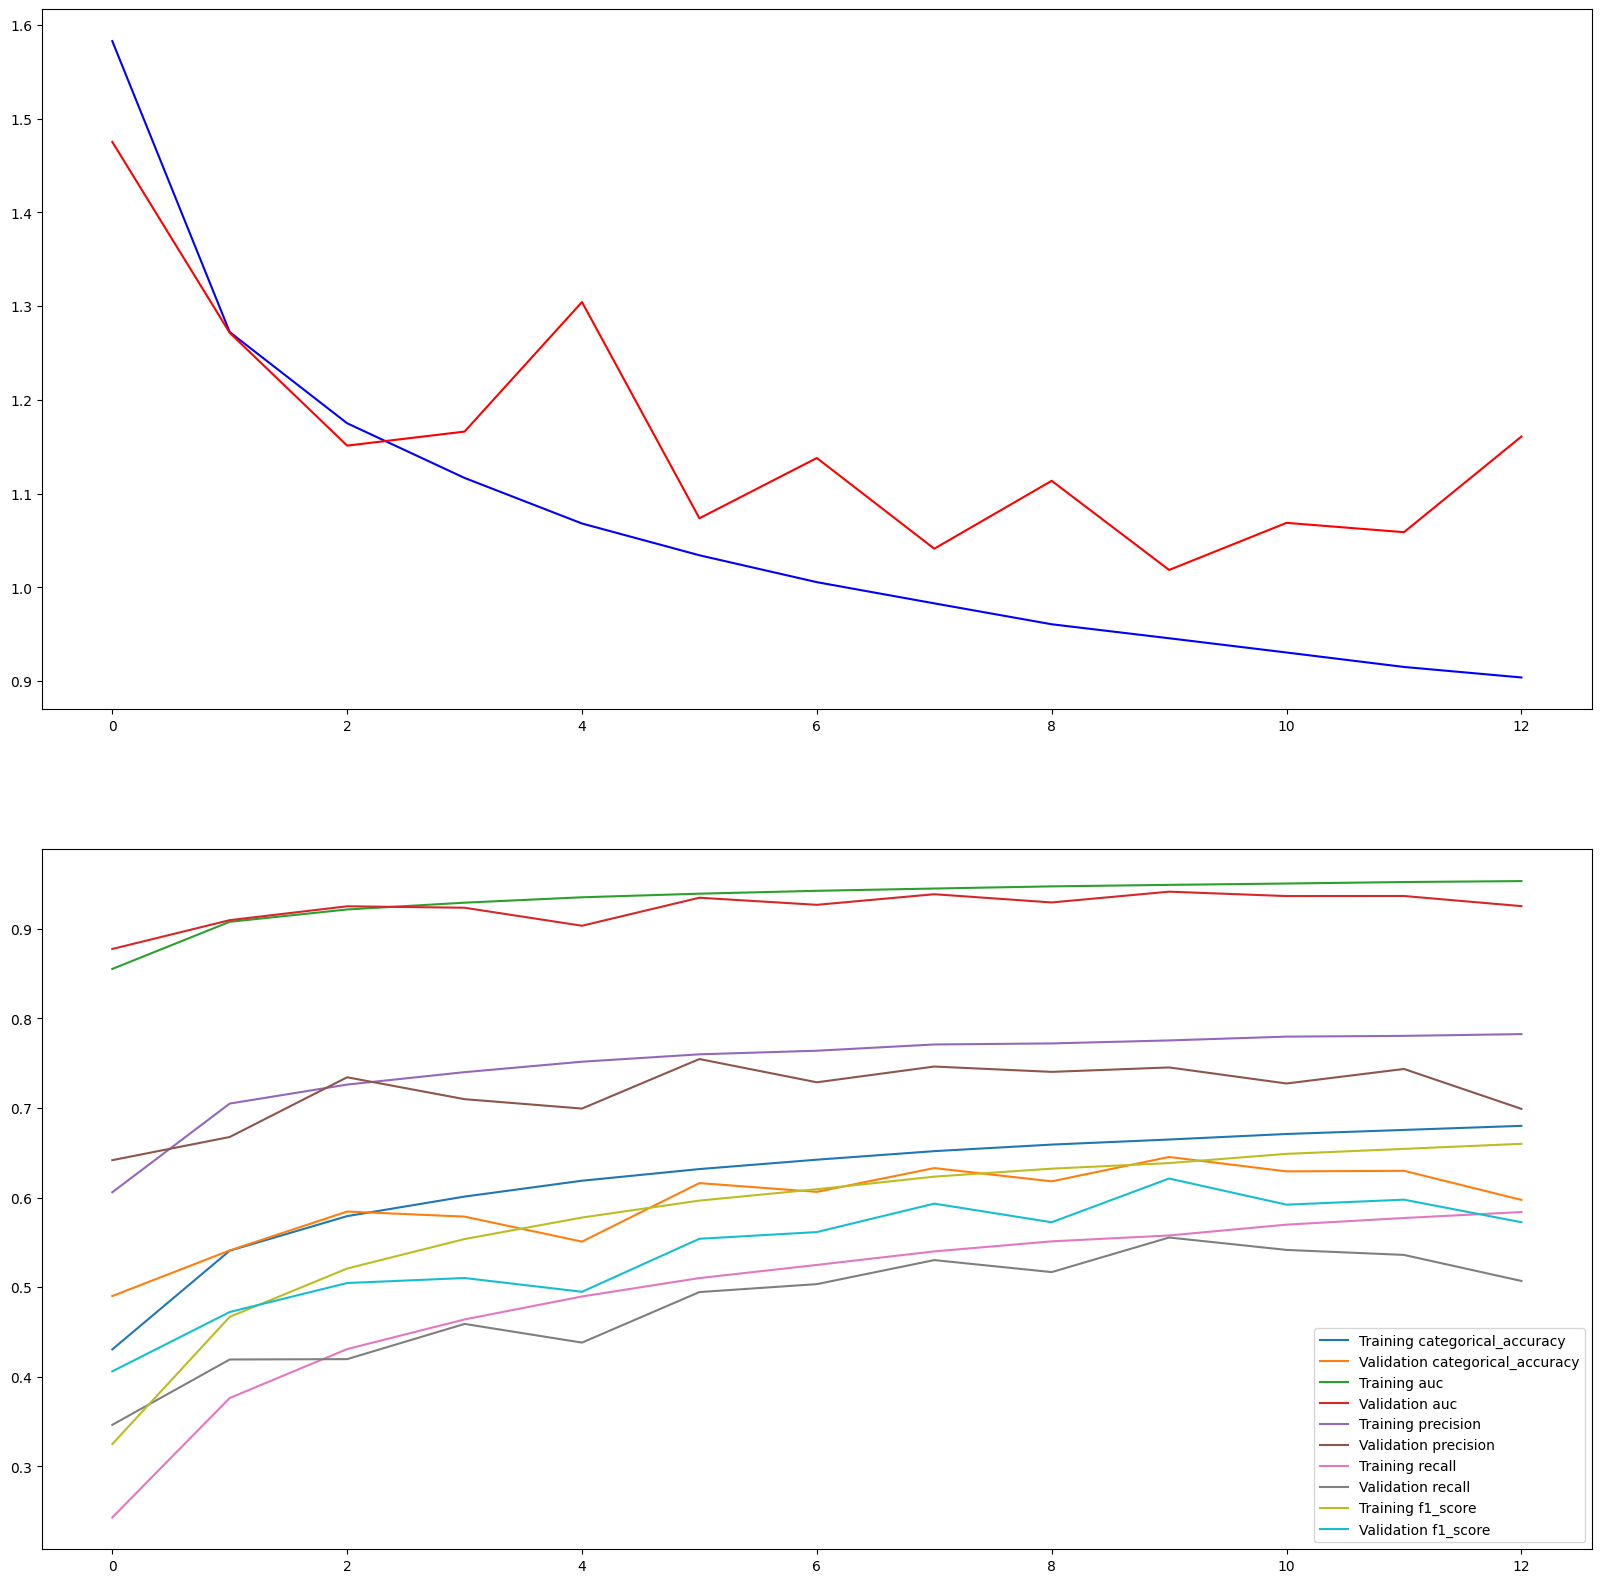

In [20]:
show_training_validation_loss_and_metrics(model1,metrics2)

In [21]:
model1.evaluate(test_it)

5625/5625 [==============================] - 198s 35ms/step - loss: 1.1724 - categorical_accuracy: 0.5970 - auc: 0.9237 - precision: 0.7009 - recall: 0.5071 - f1_score: 0.5730


[1.1723953485488892,
 0.5969889163970947,
 0.9237498044967651,
 0.7008784413337708,
 0.5070777535438538,
 0.5730152130126953]

5625/5625 [==============================] - 15s 3ms/step


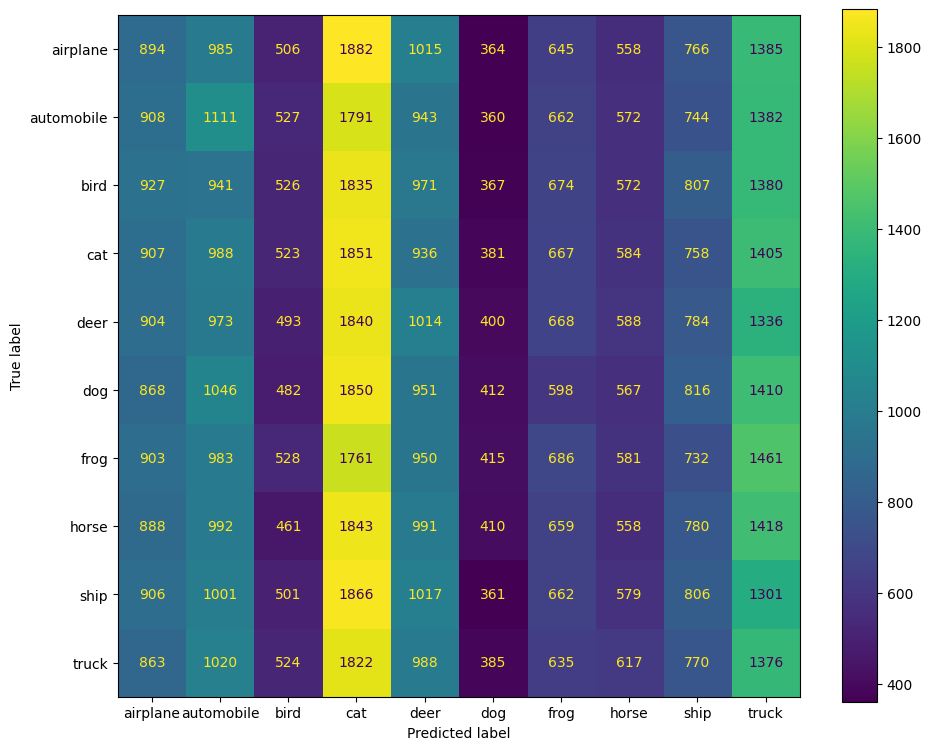

In [22]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

5625/5625 [==============================] - 12s 2ms/step


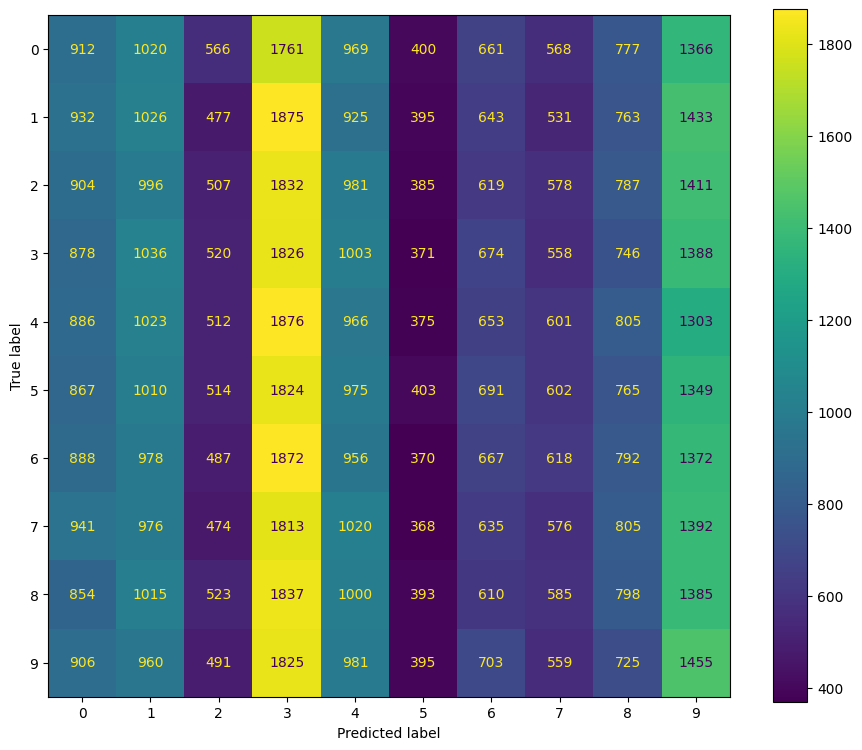

In [23]:
show_confusion_matrix_without_names(model1,test_ds,num_classes)

# Architektura drugiego modelu

In [24]:
model2 = create_model2(num_classes)

In [25]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 75)       150       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 75)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Laye  (None, 16, 16, 50)       100       
 rNormalization)                                                 
                                                      

In [27]:
history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 240s 42ms/step - loss: 1.7238 - categorical_accuracy: 0.3739 - auc: 0.8213 - precision: 0.6043 - recall: 0.1441 - f1_score: 0.4243 - val_loss: 1.5476 - val_categorical_accuracy: 0.4360 - val_auc: 0.8617 - val_precision: 0.6044 - val_recall: 0.2455 - val_f1_score: 0.3002
Epoch 2/20
5625/5625 [==============================] - 230s 41ms/step - loss: 1.4284 - categorical_accuracy: 0.4798 - auc: 0.8822 - precision: 0.6781 - recall: 0.2741 - f1_score: 0.3594 - val_loss: 1.3310 - val_categorical_accuracy: 0.5167 - val_auc: 0.8987 - val_precision: 0.7174 - val_recall: 0.3077 - val_f1_score: 0.3802
Epoch 3/20
5625/5625 [==============================] - 233s 41ms/step - loss: 1.3372 - categorical_accuracy: 0.5138 - auc: 0.8974 - precision: 0.7002 - recall: 0.3269 - f1_score: 0.4156 - val_loss: 1.2781 - val_categorical_accuracy: 0.5370 - val_auc: 0.9067 - val_precision: 0.7024 - val_recall: 0.3762 - val_f1_score: 0.4500
Epoch 4/20
5625/562

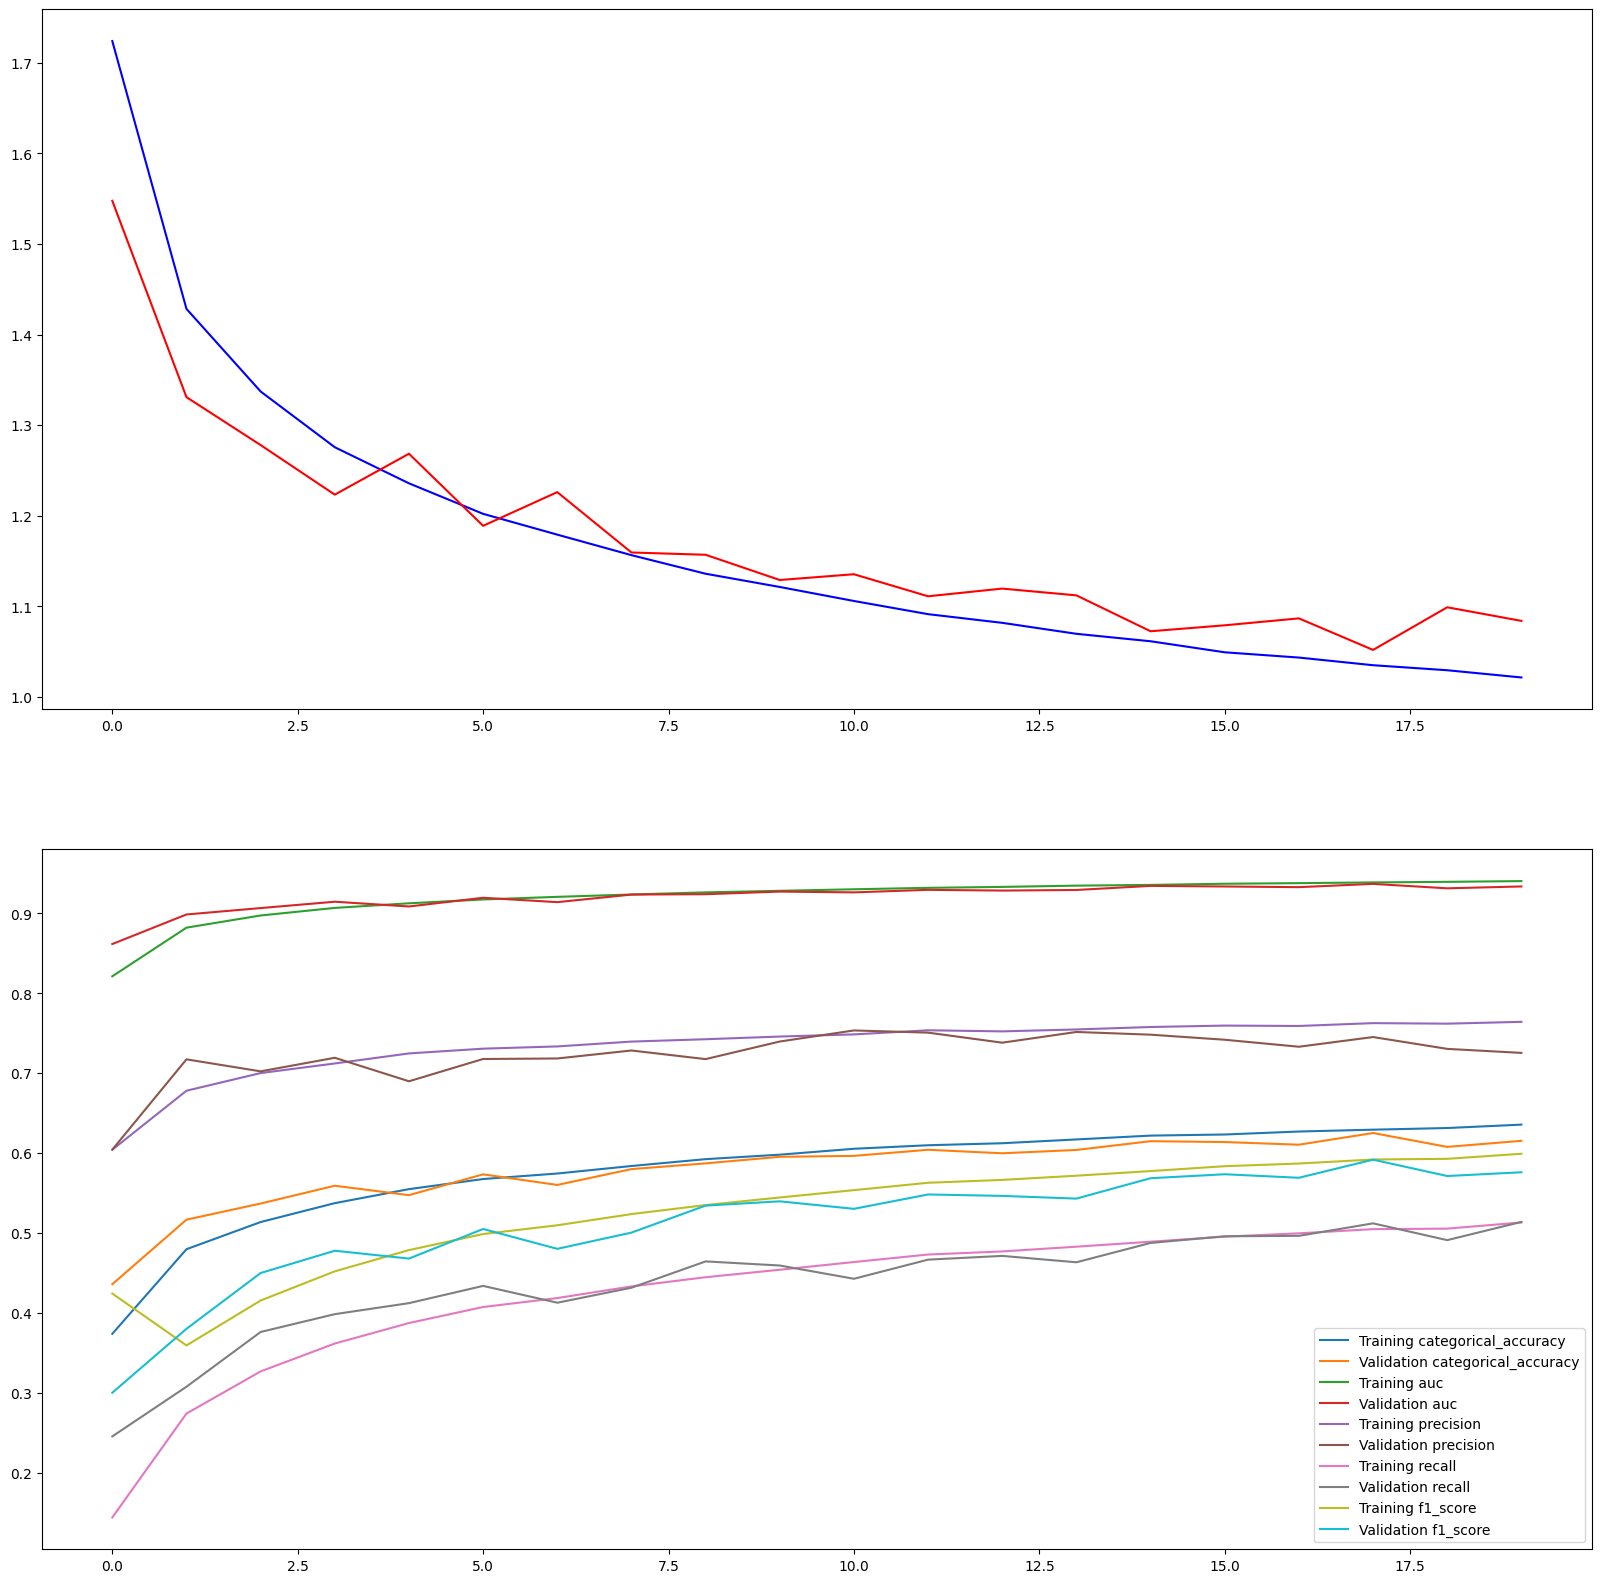

In [28]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [29]:
model2.evaluate(test_it)

5625/5625 [==============================] - 82s 15ms/step - loss: 1.0907 - categorical_accuracy: 0.6136 - auc: 0.9328 - precision: 0.7229 - recall: 0.5125 - f1_score: 0.5743


[1.090716004371643,
 0.6135777831077576,
 0.9328385591506958,
 0.7228603959083557,
 0.512499988079071,
 0.574317455291748]

5625/5625 [==============================] - 16s 3ms/step


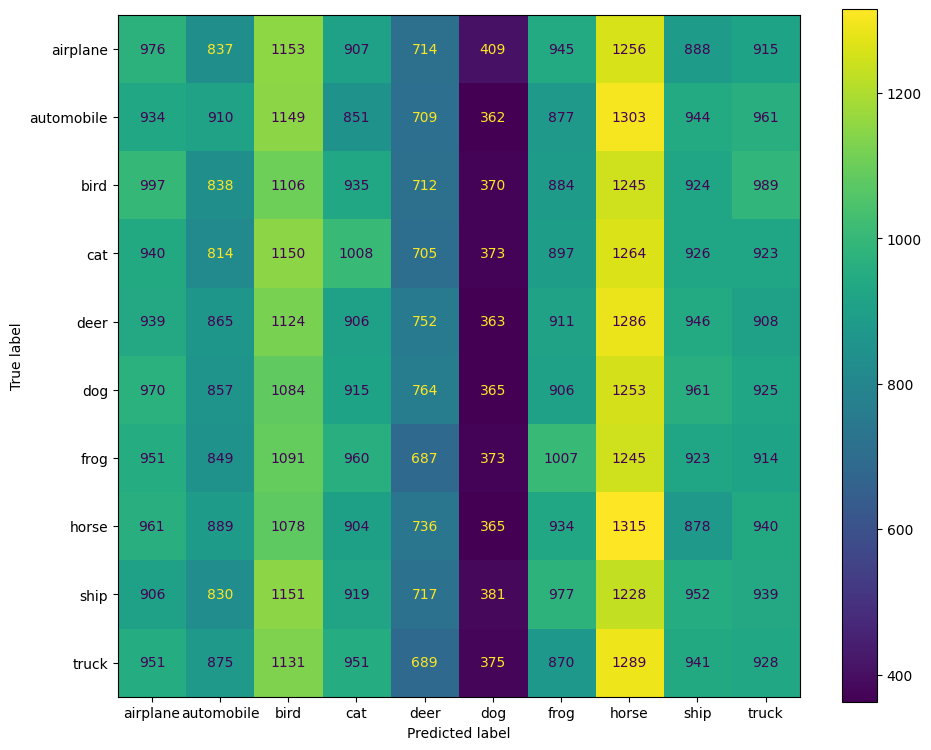

In [30]:
show_confusion_matrix(model2,test_ds,num_classes,class_names)

5625/5625 [==============================] - 15s 3ms/step


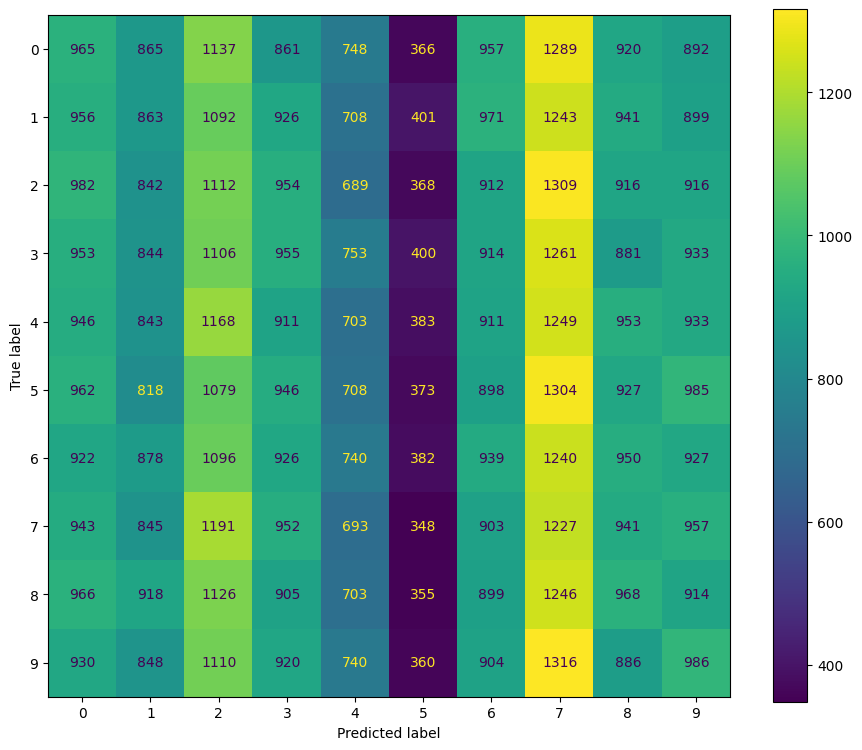

In [31]:
show_confusion_matrix_without_names(model2,test_ds,num_classes)

# Architektura trzeciego modelu

In [32]:
model3 = create_model3(num_classes)

In [33]:
model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [34]:
history = model3.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 217s 38ms/step - loss: 1.6934 - categorical_accuracy: 0.3652 - auc: 0.8268 - precision: 0.6232 - recall: 0.1281 - f1_score: 0.4179 - val_loss: 1.4588 - val_categorical_accuracy: 0.4569 - val_auc: 0.8770 - val_precision: 0.6533 - val_recall: 0.2678 - val_f1_score: 0.3287
Epoch 2/20
5625/5625 [==============================] - 223s 40ms/step - loss: 1.4136 - categorical_accuracy: 0.4776 - auc: 0.8850 - precision: 0.6783 - recall: 0.2750 - f1_score: 0.3549 - val_loss: 1.3482 - val_categorical_accuracy: 0.5015 - val_auc: 0.8962 - val_precision: 0.6806 - val_recall: 0.3136 - val_f1_score: 0.3789
Epoch 3/20
5625/5625 [==============================] - 230s 41ms/step - loss: 1.3141 - categorical_accuracy: 0.5196 - auc: 0.9013 - precision: 0.7021 - recall: 0.3344 - f1_score: 0.4186 - val_loss: 1.2912 - val_categorical_accuracy: 0.5283 - val_auc: 0.9047 - val_precision: 0.6979 - val_recall: 0.3668 - val_f1_score: 0.4327
Epoch 4/20
5625/562

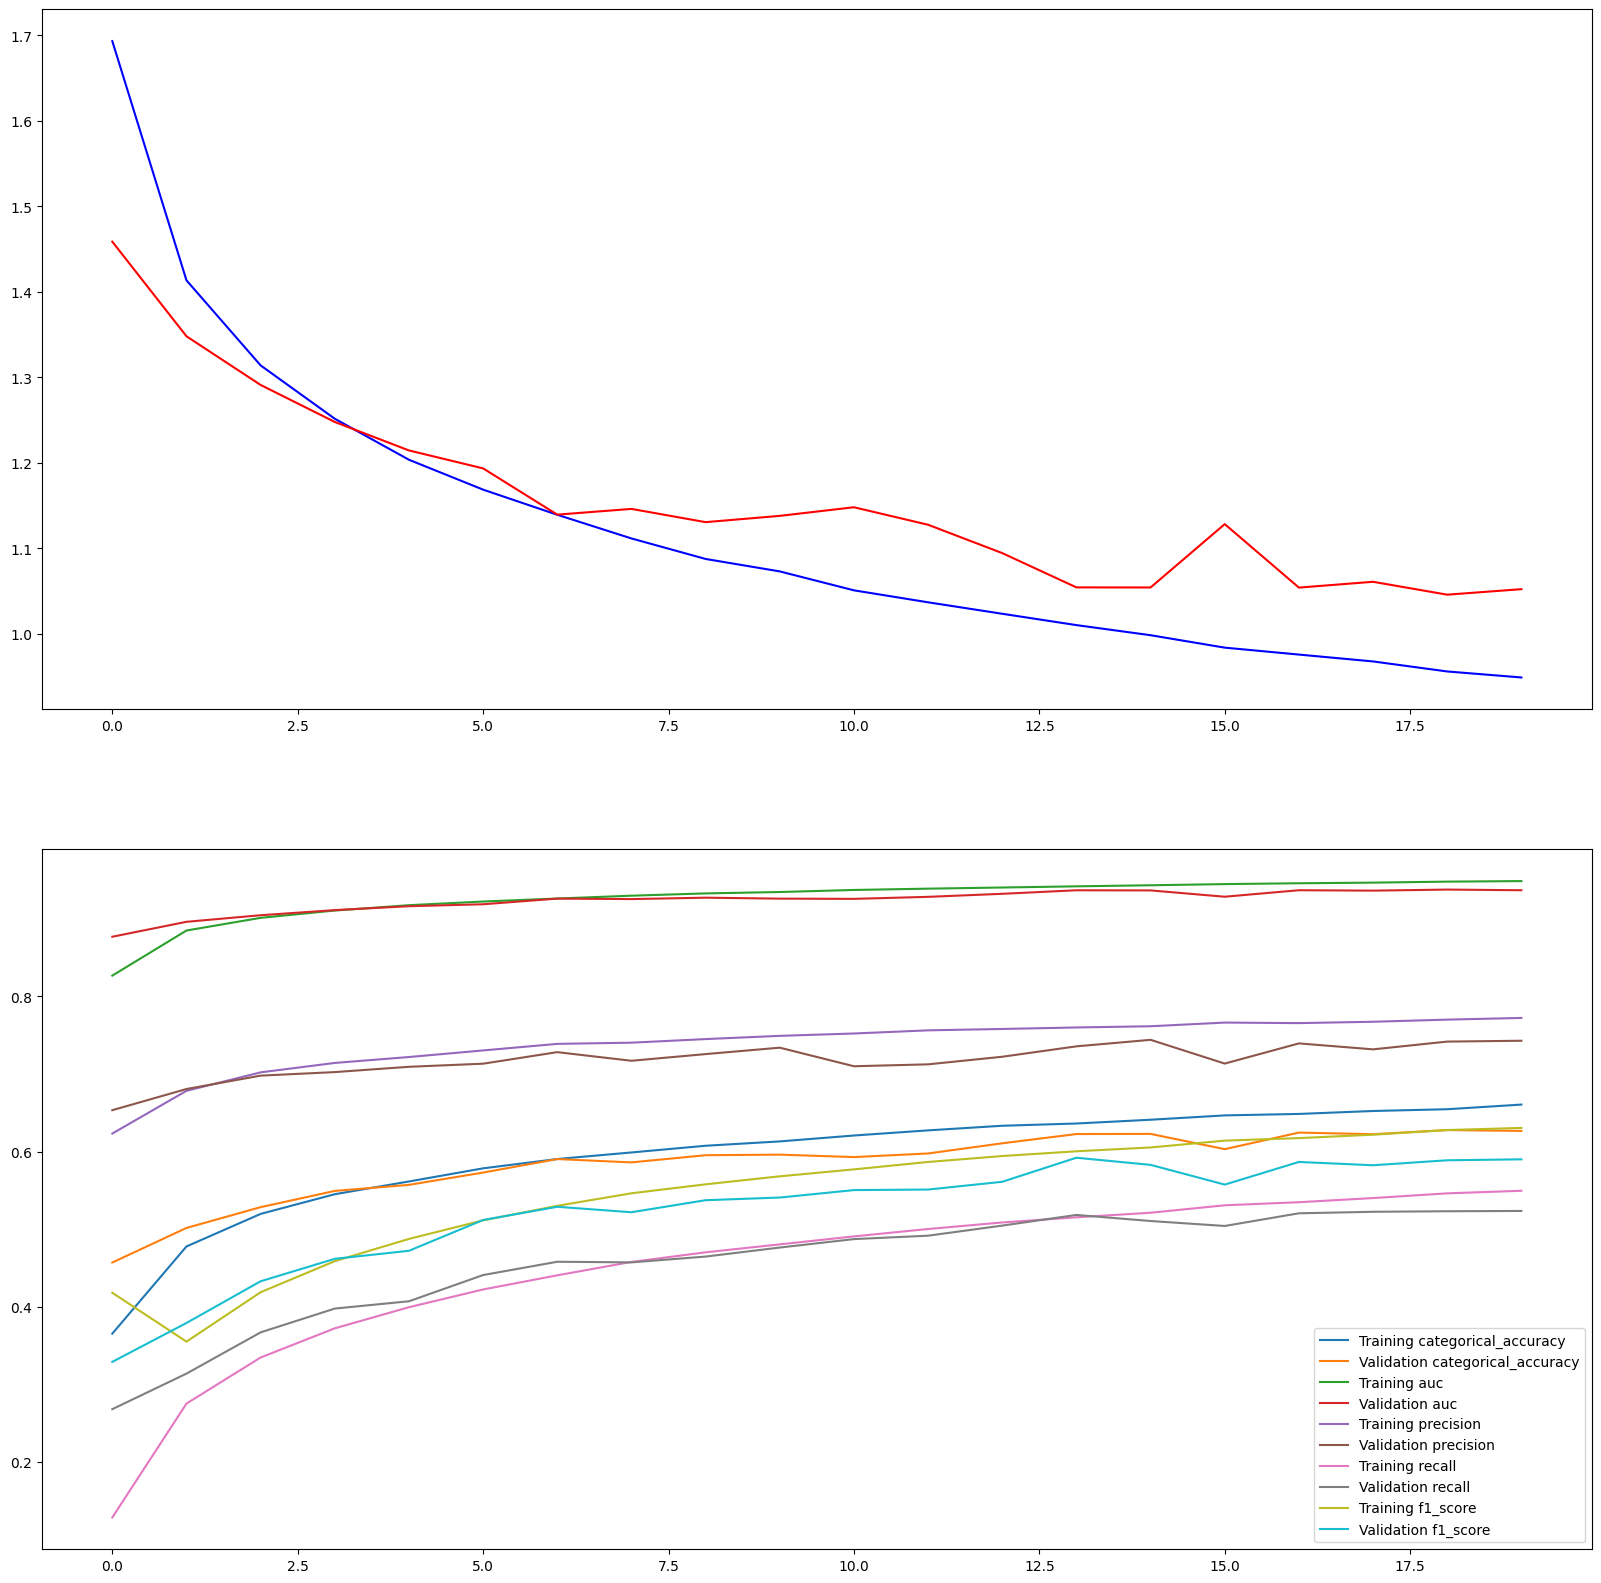

In [35]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [36]:
model3.evaluate(test_it)

5625/5625 [==============================] - 85s 15ms/step - loss: 1.0642 - categorical_accuracy: 0.6241 - auc: 0.9356 - precision: 0.7405 - recall: 0.5209 - f1_score: 0.5883


[1.0642054080963135,
 0.6240555644035339,
 0.9355598092079163,
 0.7404529452323914,
 0.5209333300590515,
 0.5882669687271118]

5625/5625 [==============================] - 16s 3ms/step


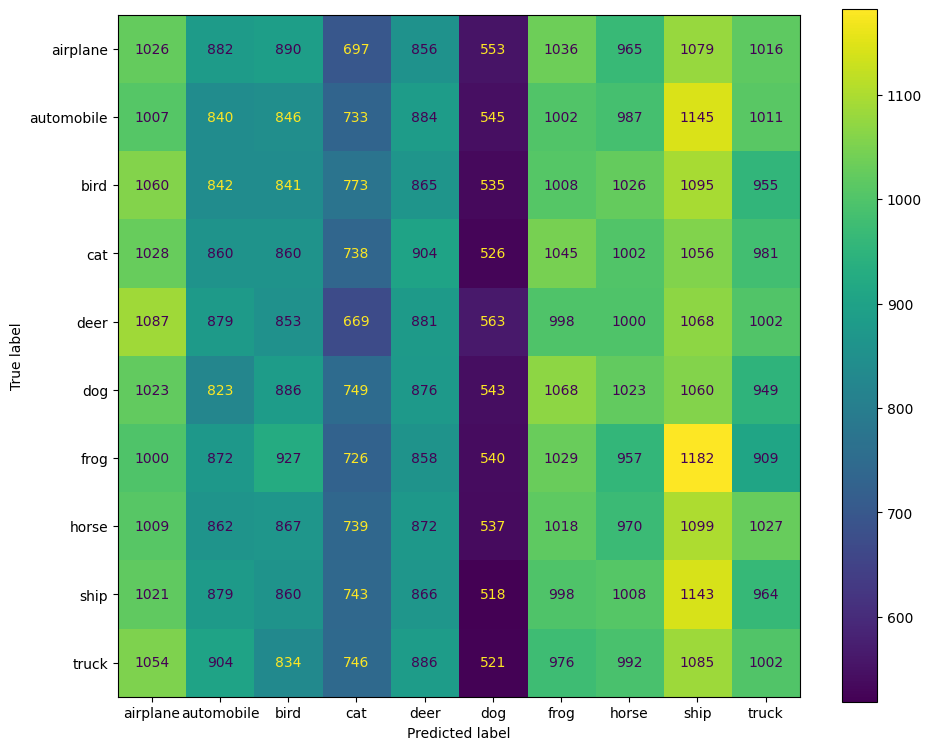

In [37]:
show_confusion_matrix(model3,test_ds,num_classes,class_names)

5625/5625 [==============================] - 16s 3ms/step


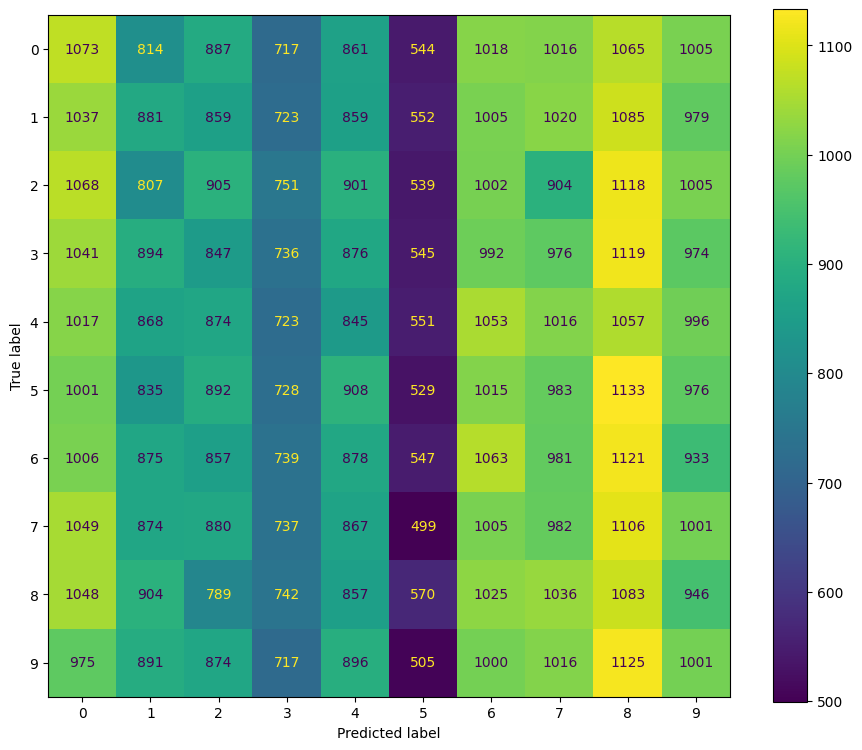

In [38]:
show_confusion_matrix_without_names(model3,test_ds,num_classes)

# Ziarno 1234

In [39]:
SEED = 1234
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [40]:
model11 = create_model1(num_classes)

In [41]:
model11.compile( 
    loss=loss_func,
    metrics=metrics
)

In [42]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [43]:
history = model11.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 174s 31ms/step - loss: 1.5827 - categorical_accuracy: 0.4288 - auc: 0.8552 - precision: 0.6012 - recall: 0.2437 - f1_score: 0.4699 - val_loss: 1.8084 - val_categorical_accuracy: 0.4200 - val_auc: 0.8288 - val_precision: 0.5556 - val_recall: 0.3295 - val_f1_score: 0.3413
Epoch 2/20
5625/5625 [==============================] - 164s 29ms/step - loss: 1.2815 - categorical_accuracy: 0.5371 - auc: 0.9062 - precision: 0.7015 - recall: 0.3706 - f1_score: 0.4598 - val_loss: 1.6485 - val_categorical_accuracy: 0.4262 - val_auc: 0.8545 - val_precision: 0.5444 - val_recall: 0.3224 - val_f1_score: 0.3204
Epoch 3/20
5625/5625 [==============================] - 156s 28ms/step - loss: 1.1833 - categorical_accuracy: 0.5766 - auc: 0.9201 - precision: 0.7285 - recall: 0.4280 - f1_score: 0.5181 - val_loss: 1.5750 - val_categorical_accuracy: 0.4675 - val_auc: 0.8701 - val_precision: 0.5690 - val_recall: 0.3628 - val_f1_score: 0.4041
Epoch 4/20
5625/562

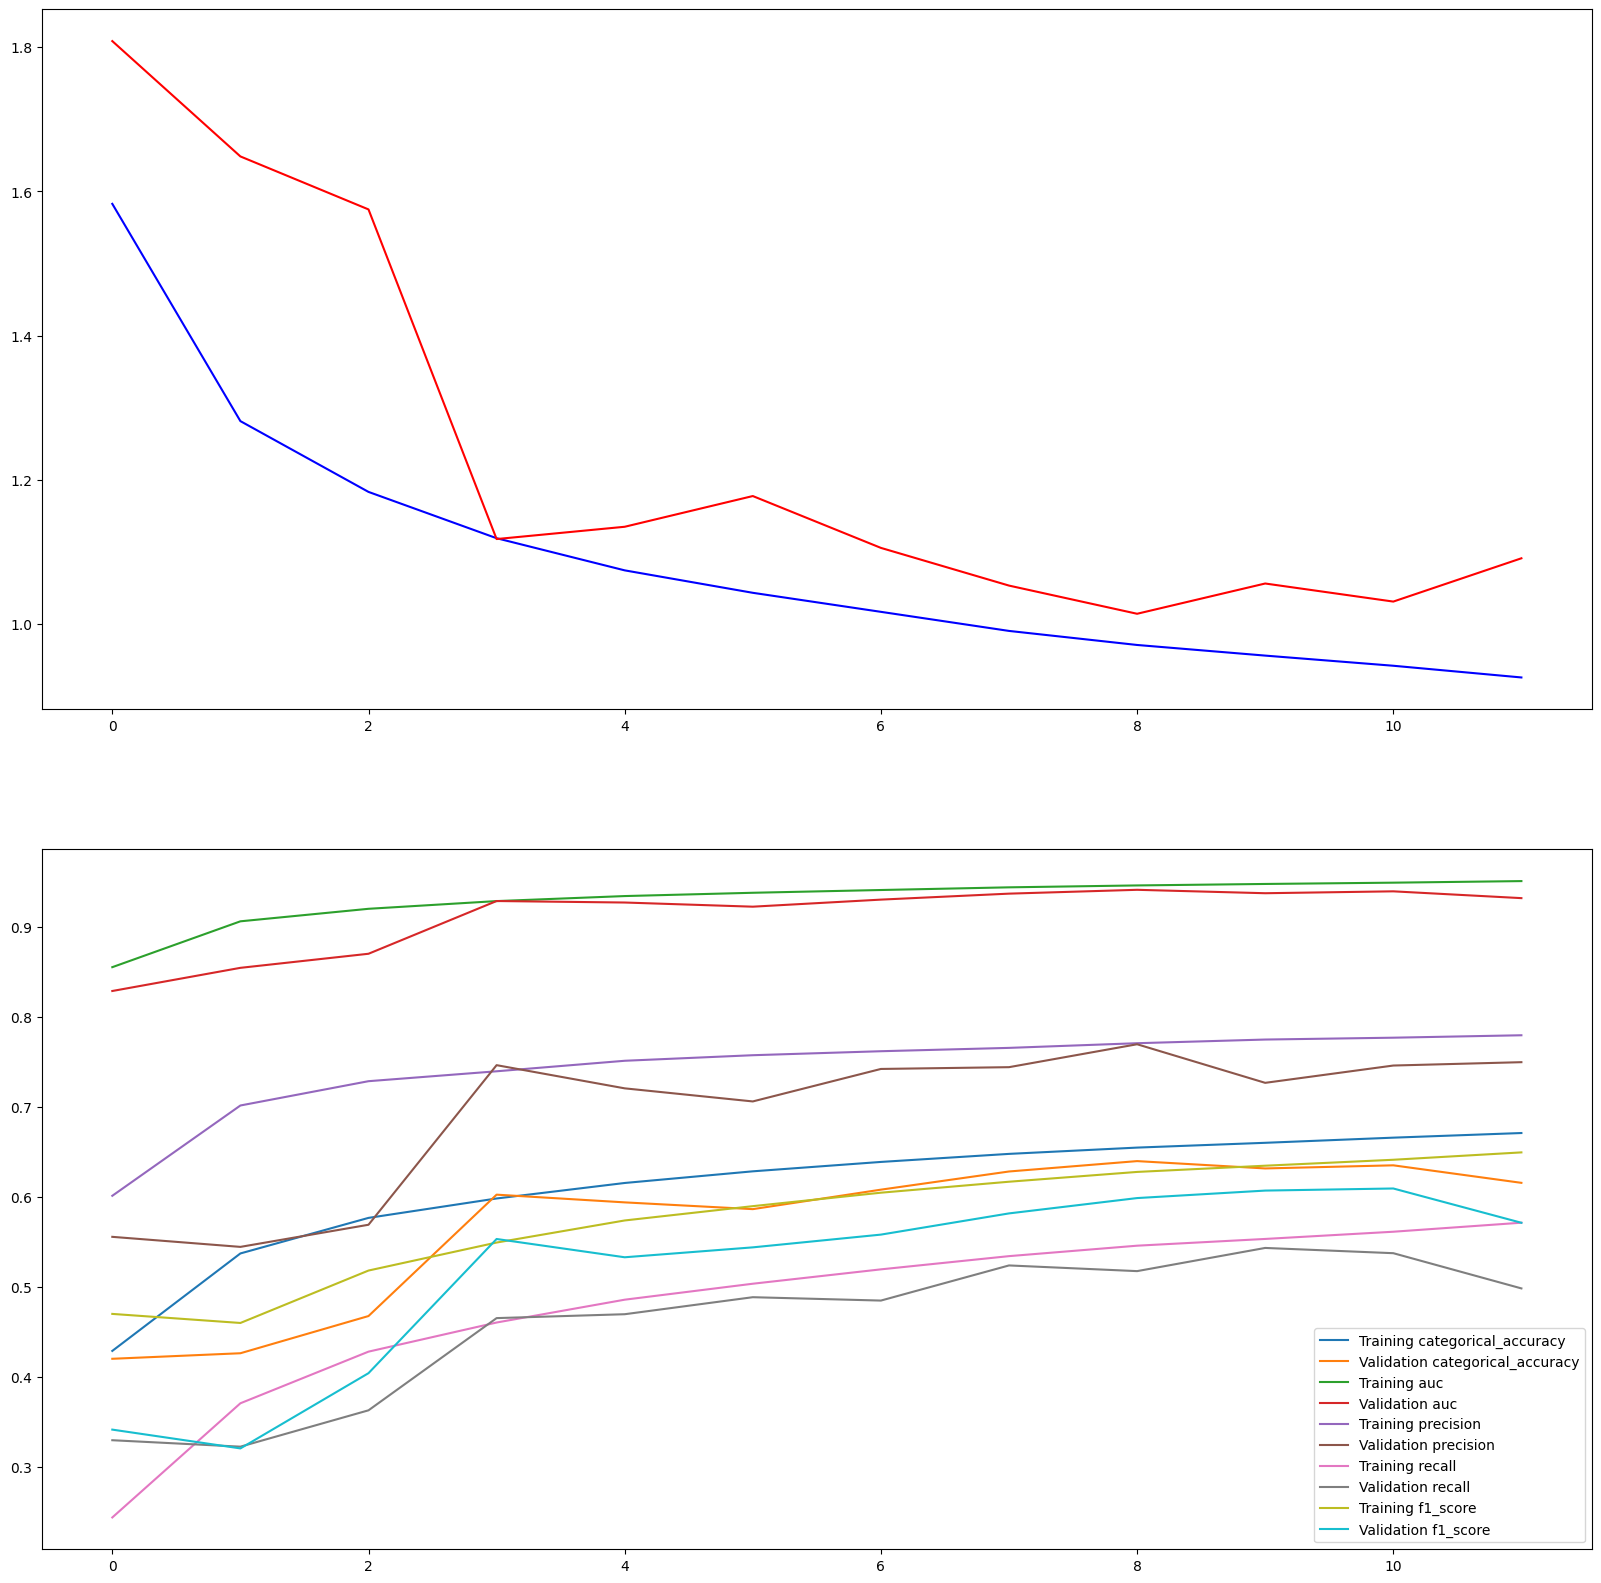

In [44]:
show_training_validation_loss_and_metrics(model11,metrics2)

In [45]:
model11.evaluate(test_it)

5625/5625 [==============================] - 91s 16ms/step - loss: 1.1017 - categorical_accuracy: 0.6106 - auc: 0.9307 - precision: 0.7442 - recall: 0.4964 - f1_score: 0.5687


[1.101683259010315,
 0.6105777621269226,
 0.9306672811508179,
 0.7441616654396057,
 0.49638888239860535,
 0.5687416791915894]

5625/5625 [==============================] - 15s 3ms/step


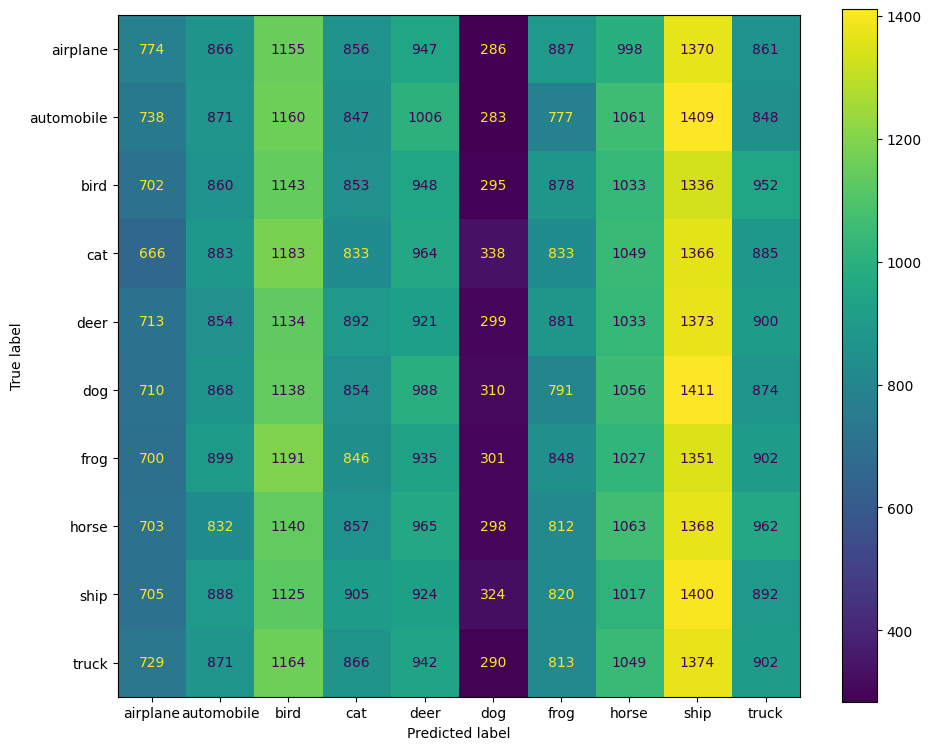

In [46]:
show_confusion_matrix(model11,test_ds,num_classes,class_names)

5625/5625 [==============================] - 13s 2ms/step


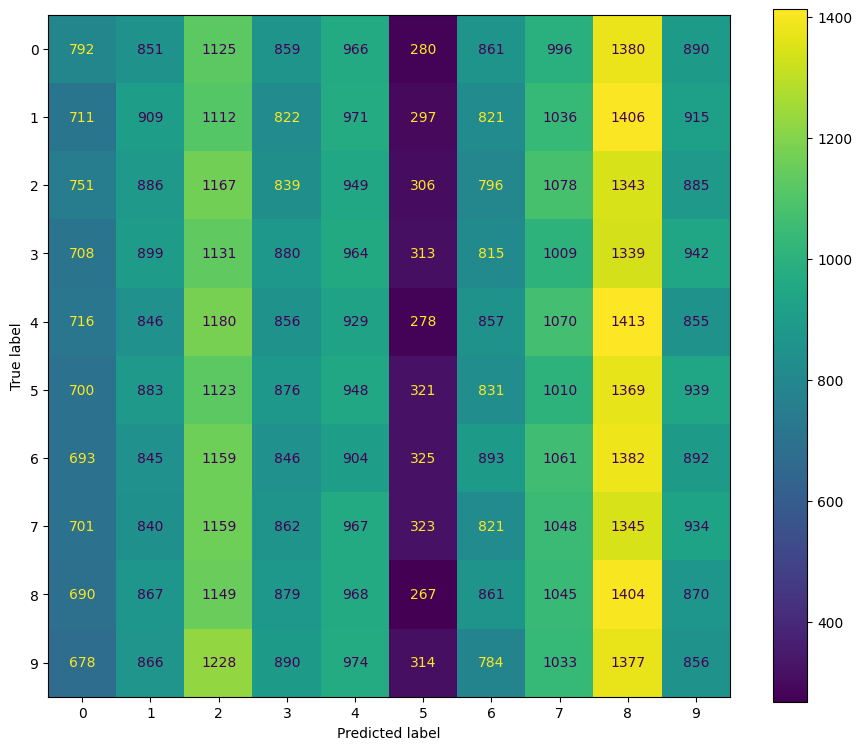

In [47]:
show_confusion_matrix_without_names(model11,test_ds,num_classes)

# Architektura drugiego modelu

In [48]:
model21 = create_model2(num_classes)

In [49]:
model21.compile( 
    loss=loss_func,
    metrics=metrics
)

In [50]:
model21.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_9 (Laye  (None, 32, 32, 75)       150       
 rNormalization)                                                 
                                                                 
 average_pooling2d_3 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_10 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [51]:
history = model21.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.7067 - categorical_accuracy: 0.3809 - auc: 0.8264 - precision: 0.6029 - recall: 0.1544 - f1_score: 0.4236 - val_loss: 1.4971 - val_categorical_accuracy: 0.4495 - val_auc: 0.8713 - val_precision: 0.6131 - val_recall: 0.2856 - val_f1_score: 0.3359
Epoch 2/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.4112 - categorical_accuracy: 0.4854 - auc: 0.8853 - precision: 0.6786 - recall: 0.2839 - f1_score: 0.3702 - val_loss: 1.3475 - val_categorical_accuracy: 0.5130 - val_auc: 0.8969 - val_precision: 0.7349 - val_recall: 0.2806 - val_f1_score: 0.3674
Epoch 3/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.3264 - categorical_accuracy: 0.5213 - auc: 0.8992 - precision: 0.6970 - recall: 0.3331 - f1_score: 0.4228 - val_loss: 1.2900 - val_categorical_accuracy: 0.5287 - val_auc: 0.9051 - val_precision: 0.7059 - val_recall: 0.3421 - val_f1_score: 0.4269
Epoch 4/20
5625/562

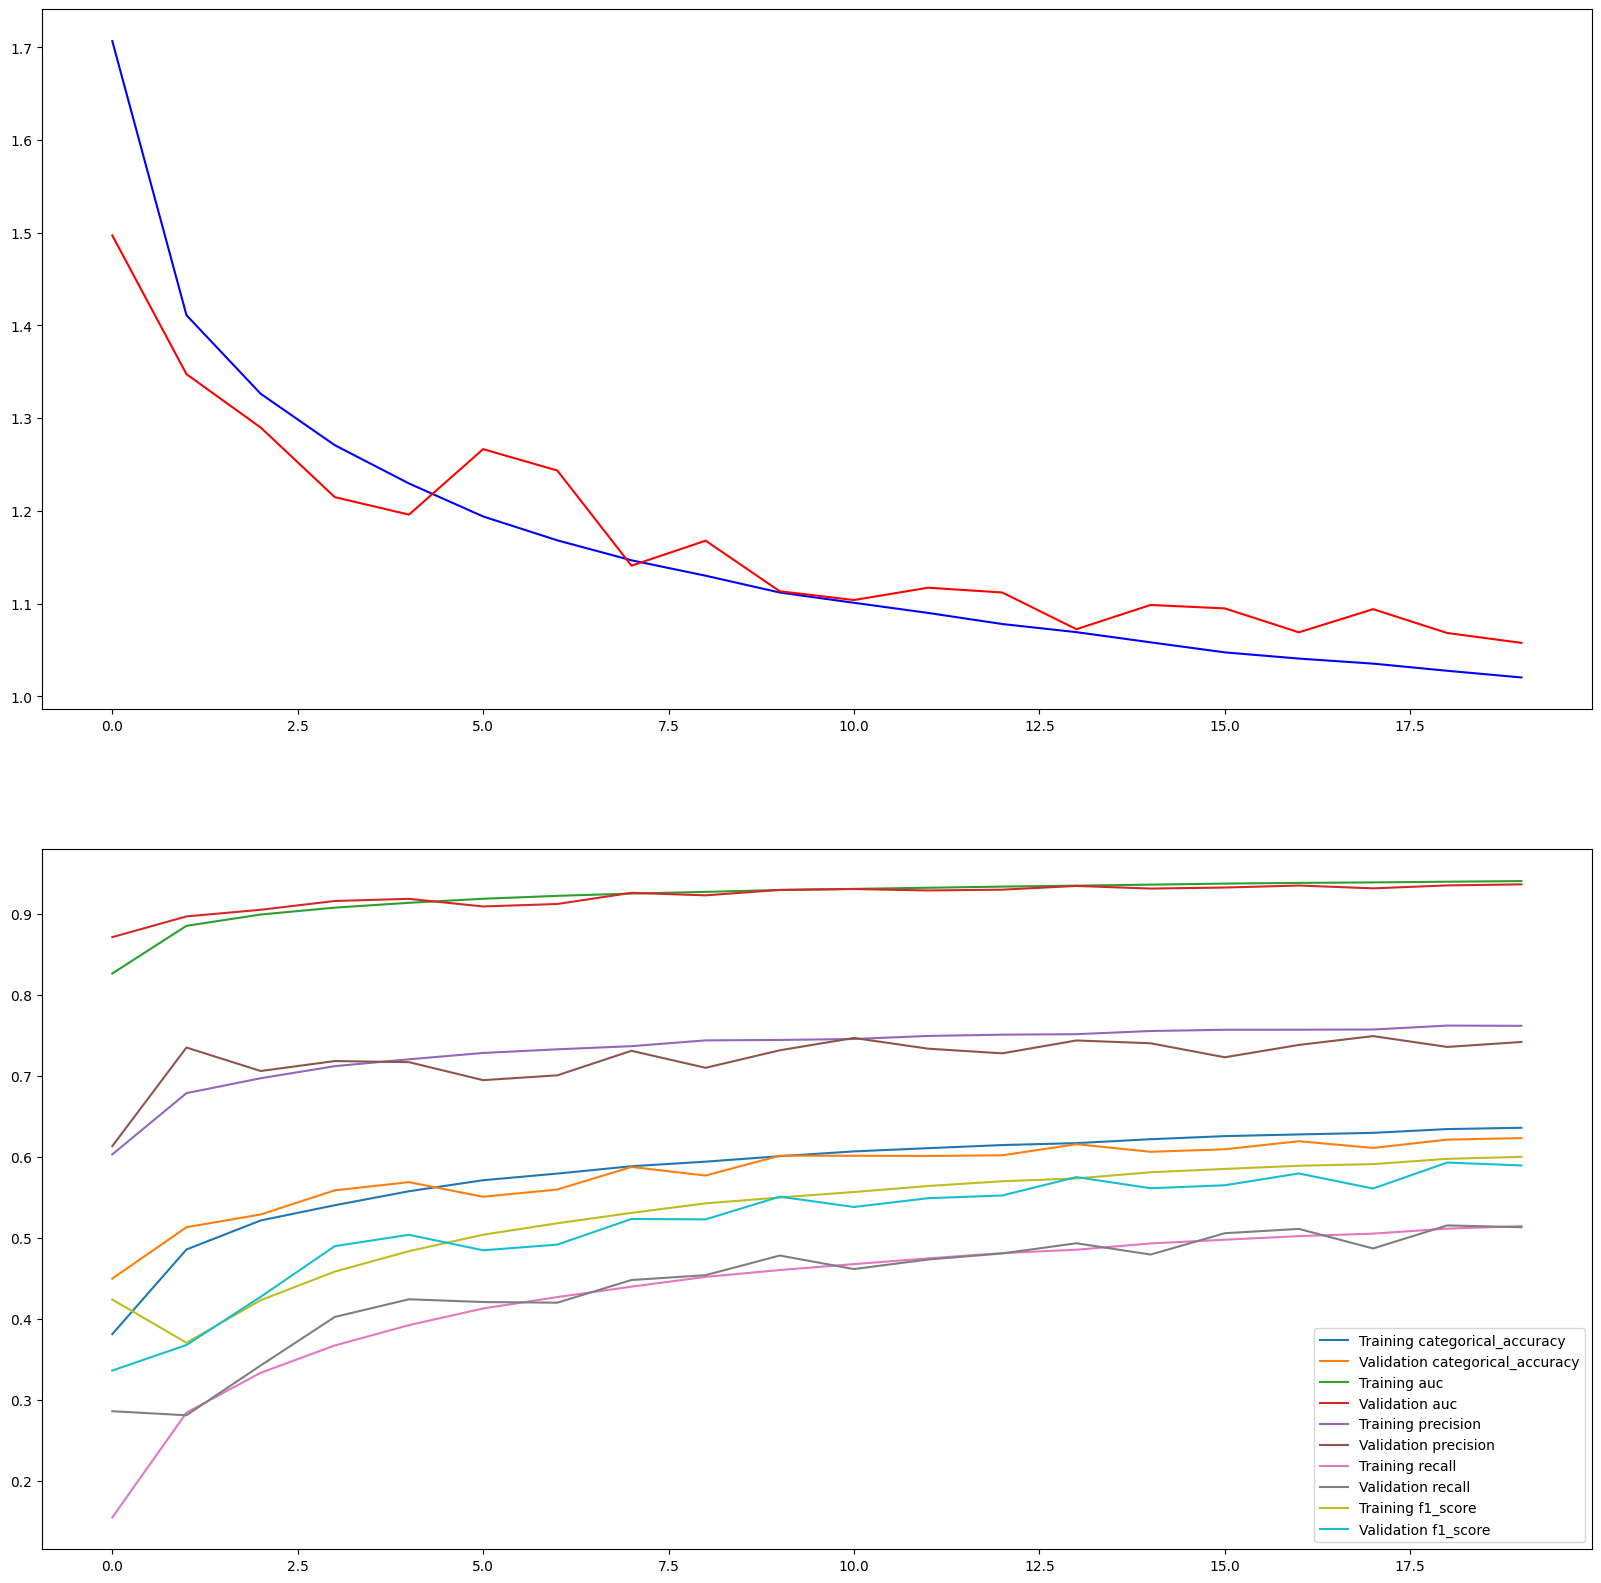

In [52]:
show_training_validation_loss_and_metrics(model21,metrics2)

In [53]:
model21.evaluate(test_it)

5625/5625 [==============================] - 63s 11ms/step - loss: 1.0634 - categorical_accuracy: 0.6241 - auc: 0.9357 - precision: 0.7399 - recall: 0.5152 - f1_score: 0.5904


[1.0634357929229736,
 0.6241000294685364,
 0.935697615146637,
 0.7398707270622253,
 0.515155553817749,
 0.590436577796936]

5625/5625 [==============================] - 17s 3ms/step


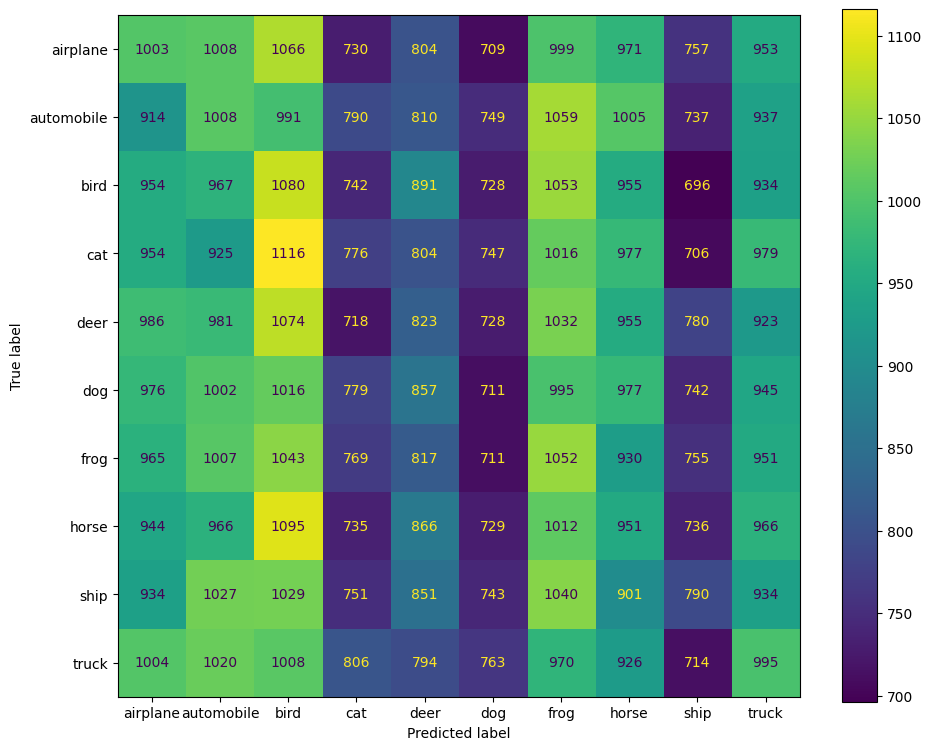

In [54]:
show_confusion_matrix(model21,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


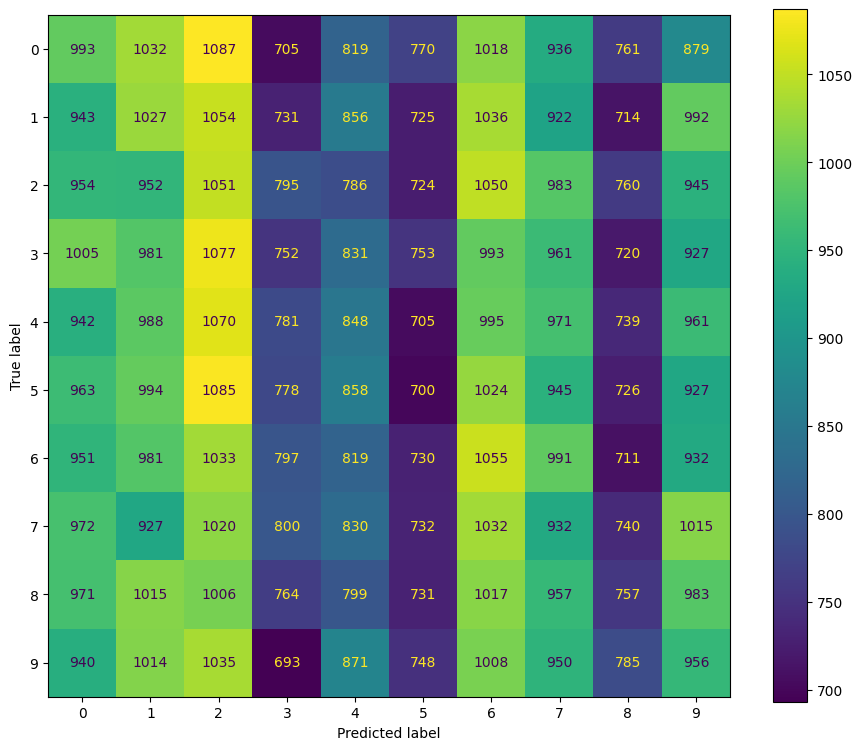

In [55]:
show_confusion_matrix_without_names(model21,test_ds,num_classes)

# Architektura trzeciego modelu

In [56]:
model31 = create_model3(num_classes)

model31.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [57]:
history = model31.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.6866 - categorical_accuracy: 0.3675 - auc: 0.8286 - precision: 0.6241 - recall: 0.1290 - f1_score: 0.4263 - val_loss: 1.4403 - val_categorical_accuracy: 0.4609 - val_auc: 0.8810 - val_precision: 0.6605 - val_recall: 0.2315 - val_f1_score: 0.2920
Epoch 2/20
5625/5625 [==============================] - 146s 26ms/step - loss: 1.4071 - categorical_accuracy: 0.4815 - auc: 0.8859 - precision: 0.6817 - recall: 0.2773 - f1_score: 0.3563 - val_loss: 1.3198 - val_categorical_accuracy: 0.5162 - val_auc: 0.9004 - val_precision: 0.7001 - val_recall: 0.3373 - val_f1_score: 0.4114
Epoch 3/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.2982 - categorical_accuracy: 0.5246 - auc: 0.9037 - precision: 0.7042 - recall: 0.3415 - f1_score: 0.4243 - val_loss: 1.2272 - val_categorical_accuracy: 0.5498 - val_auc: 0.9144 - val_precision: 0.7164 - val_recall: 0.3838 - val_f1_score: 0.4669
Epoch 4/20
5625/562

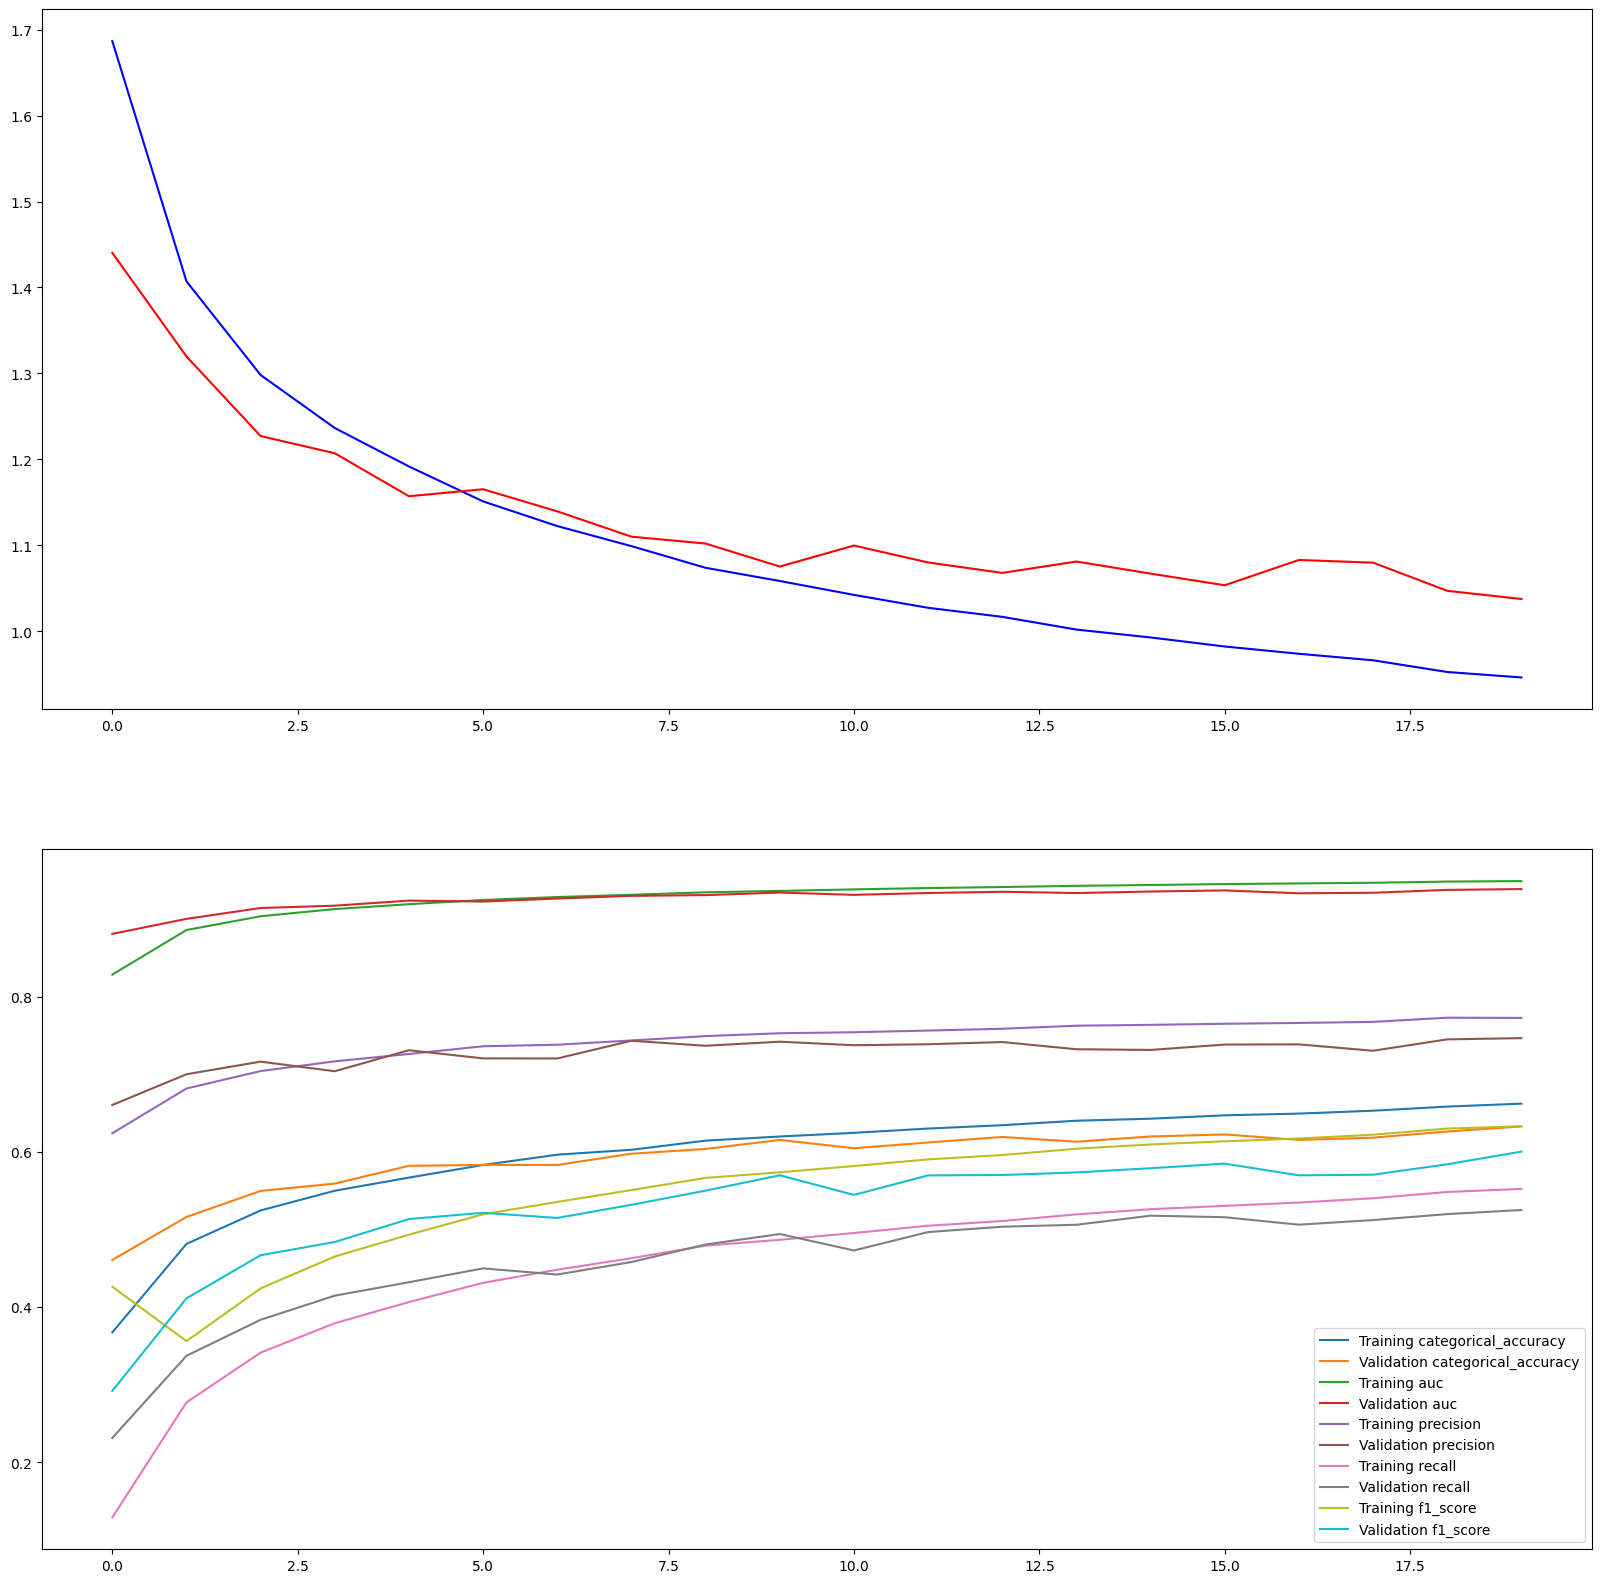

In [58]:
show_training_validation_loss_and_metrics(model31,metrics2)

In [59]:
model31.evaluate(test_it)

5625/5625 [==============================] - 62s 11ms/step - loss: 1.0479 - categorical_accuracy: 0.6304 - auc: 0.9374 - precision: 0.7433 - recall: 0.5251 - f1_score: 0.5998


[1.0479357242584229,
 0.6304444670677185,
 0.9373949766159058,
 0.7433421015739441,
 0.5250555276870728,
 0.5997883677482605]

5625/5625 [==============================] - 17s 3ms/step


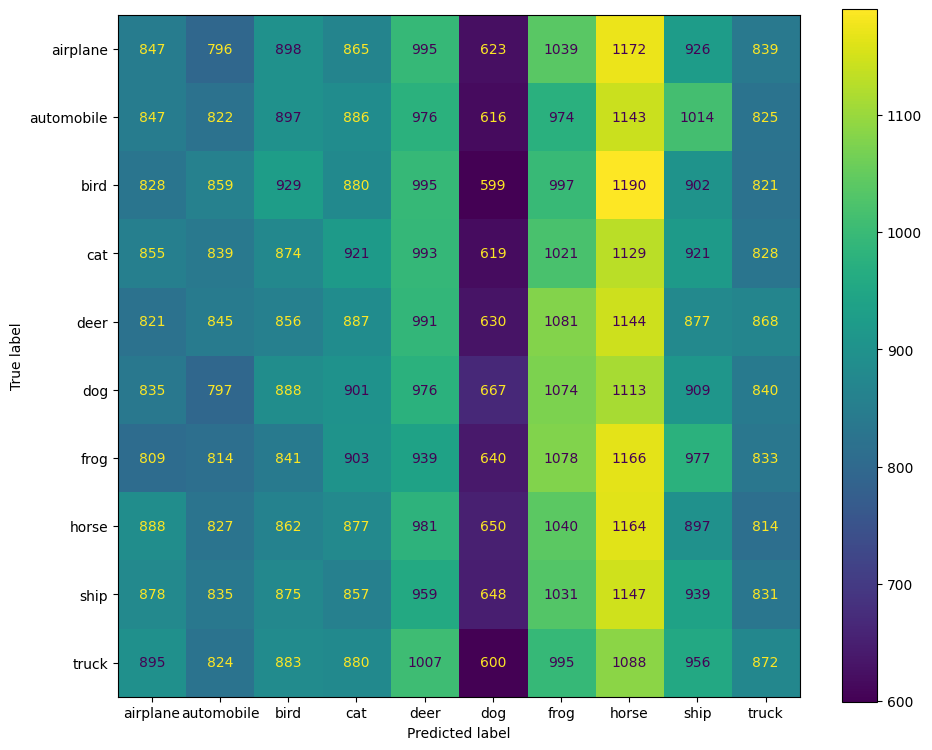

In [60]:
show_confusion_matrix(model31,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


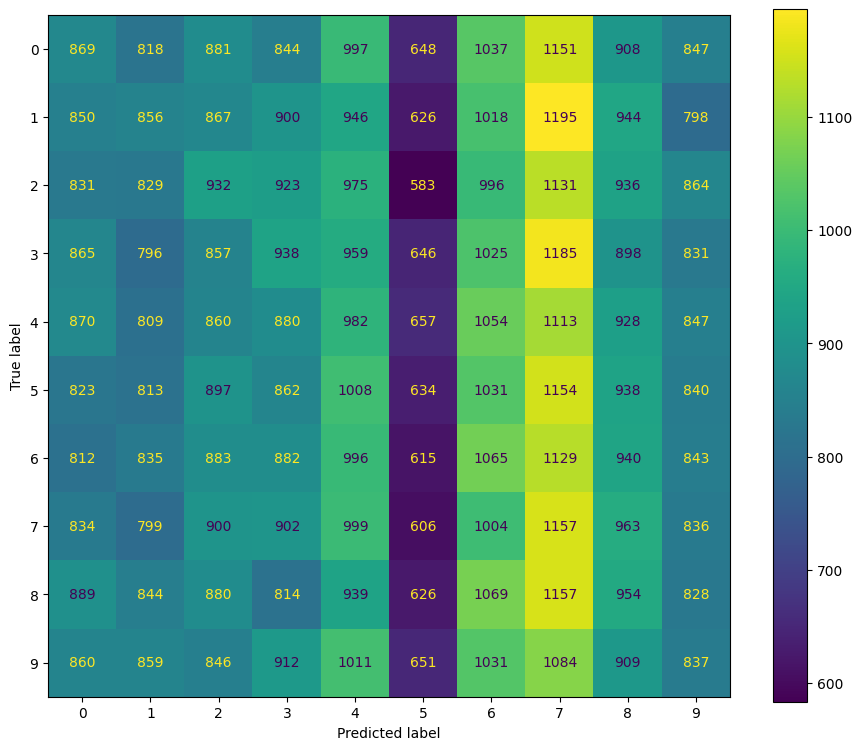

In [61]:
show_confusion_matrix_without_names(model31,test_ds,num_classes)

# Ziarno 2137

In [62]:
SEED = 2137

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [63]:
model12 = create_model1(num_classes)

In [64]:
model12.compile( 
    loss=loss_func,
    metrics=metrics
)

In [65]:
model12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [66]:
history = model12.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 152s 27ms/step - loss: 1.5841 - categorical_accuracy: 0.4292 - auc: 0.8550 - precision: 0.6023 - recall: 0.2425 - f1_score: 0.4762 - val_loss: 1.5614 - val_categorical_accuracy: 0.4538 - val_auc: 0.8662 - val_precision: 0.5769 - val_recall: 0.3158 - val_f1_score: 0.3502
Epoch 2/20
5625/5625 [==============================] - 150s 27ms/step - loss: 1.2788 - categorical_accuracy: 0.5388 - auc: 0.9066 - precision: 0.7033 - recall: 0.3752 - f1_score: 0.4655 - val_loss: 1.3506 - val_categorical_accuracy: 0.5010 - val_auc: 0.8968 - val_precision: 0.6453 - val_recall: 0.3419 - val_f1_score: 0.4137
Epoch 3/20
5625/5625 [==============================] - 155s 28ms/step - loss: 1.1816 - categorical_accuracy: 0.5748 - auc: 0.9205 - precision: 0.7228 - recall: 0.4293 - f1_score: 0.5193 - val_loss: 1.1332 - val_categorical_accuracy: 0.5936 - val_auc: 0.9271 - val_precision: 0.7590 - val_recall: 0.4320 - val_f1_score: 0.5257
Epoch 4/20
5625/562

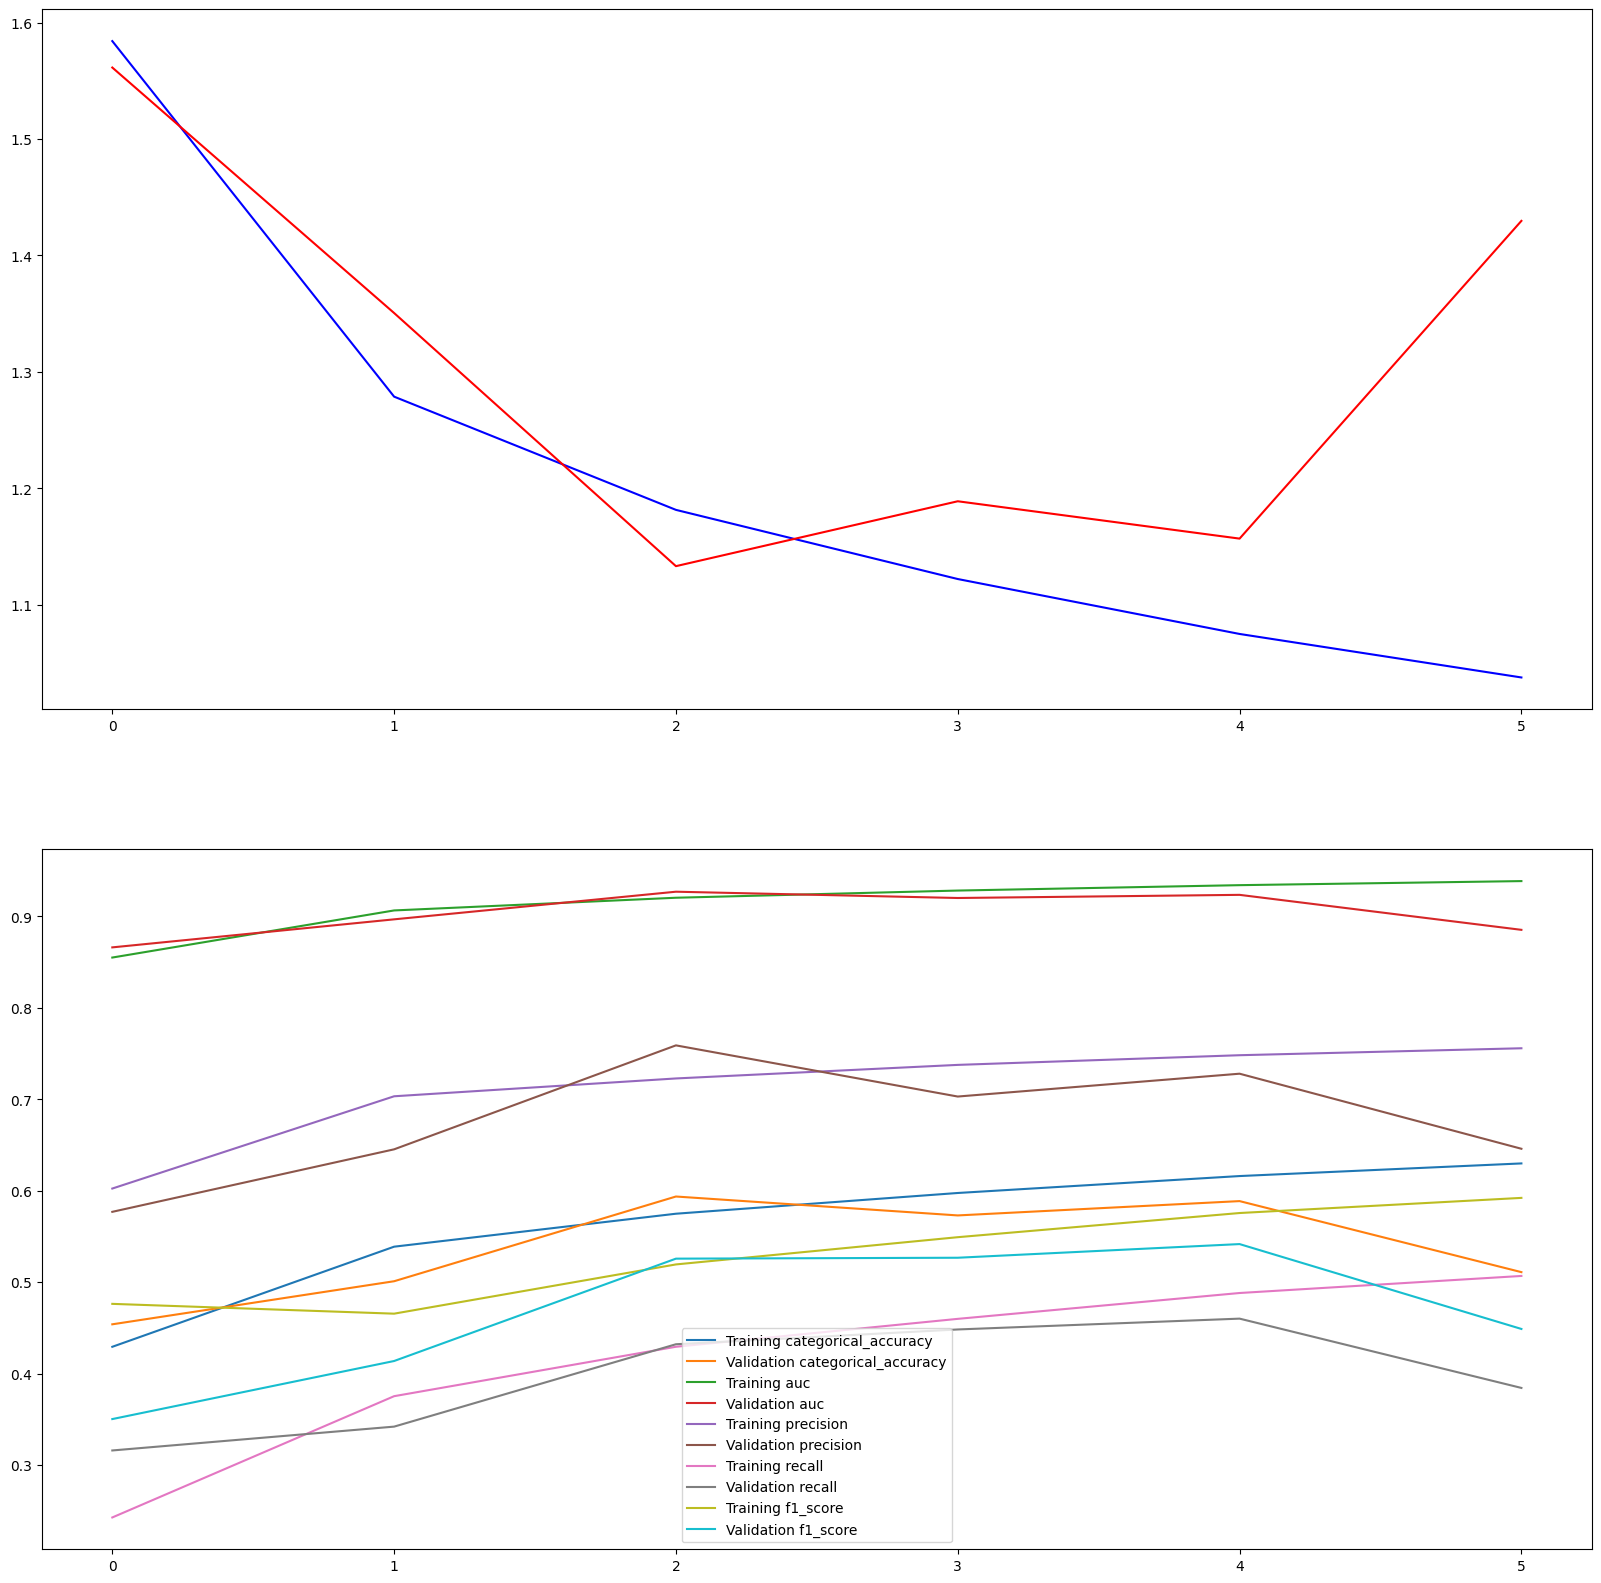

In [67]:
show_training_validation_loss_and_metrics(model12,metrics2)

In [68]:
model12.evaluate(test_it)

5625/5625 [==============================] - 62s 11ms/step - loss: 1.4372 - categorical_accuracy: 0.5081 - auc: 0.8843 - precision: 0.6429 - recall: 0.3821 - f1_score: 0.4472


[1.4371792078018188,
 0.5081333518028259,
 0.8843492269515991,
 0.6428931951522827,
 0.382099986076355,
 0.4471951425075531]

5625/5625 [==============================] - 14s 3ms/step


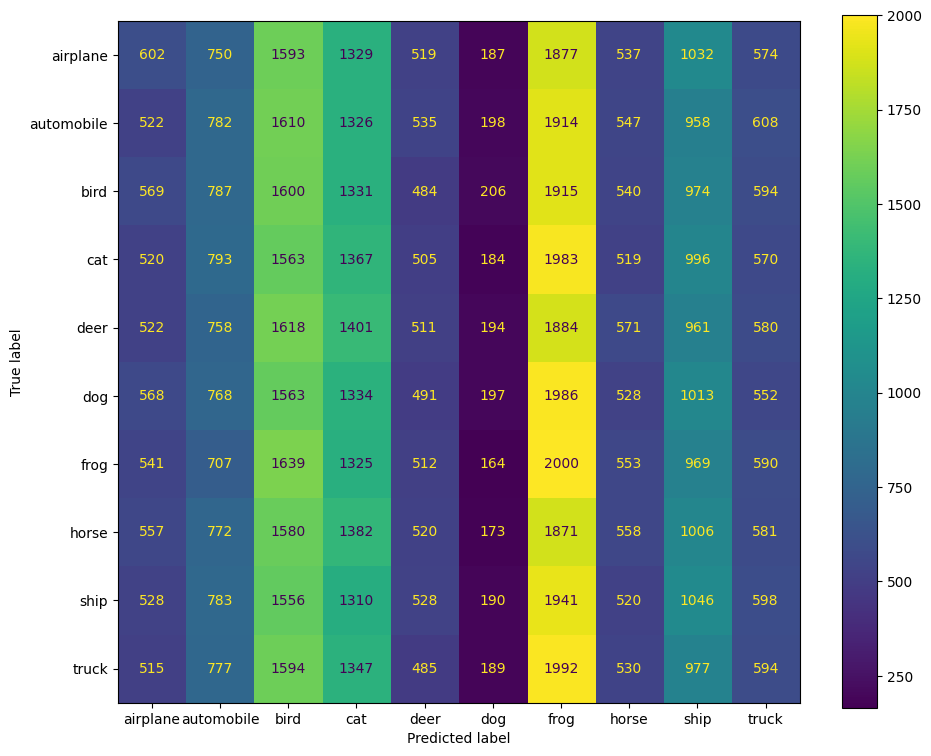

In [69]:
show_confusion_matrix(model12,test_ds,num_classes,class_names)

5625/5625 [==============================] - 14s 2ms/step


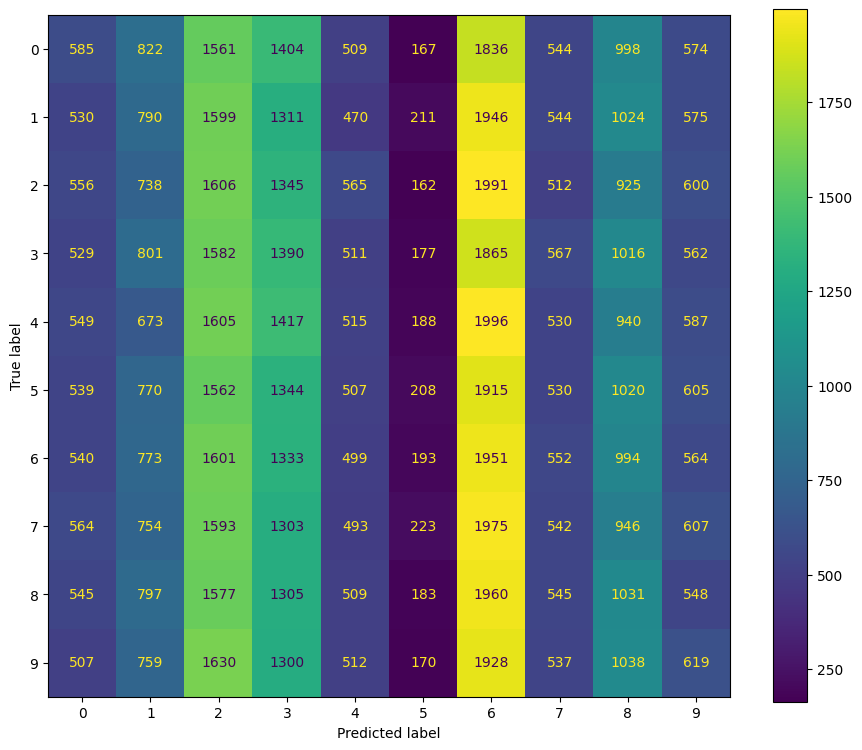

In [70]:
show_confusion_matrix_without_names(model12,test_ds,num_classes)

# Architektura drugiego modelu

In [71]:
model22 = create_model2(num_classes)

In [72]:
model22.compile( 
    loss=loss_func,
    metrics=metrics
)

In [73]:
model22.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_18 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_19 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [74]:
history = model22.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 158s 28ms/step - loss: 1.7276 - categorical_accuracy: 0.3750 - auc: 0.8218 - precision: 0.5955 - recall: 0.1481 - f1_score: 0.3520 - val_loss: 1.5000 - val_categorical_accuracy: 0.4492 - val_auc: 0.8691 - val_precision: 0.6708 - val_recall: 0.2228 - val_f1_score: 0.3044
Epoch 2/20
5625/5625 [==============================] - 153s 27ms/step - loss: 1.4453 - categorical_accuracy: 0.4729 - auc: 0.8791 - precision: 0.6756 - recall: 0.2658 - f1_score: 0.3514 - val_loss: 1.3731 - val_categorical_accuracy: 0.4915 - val_auc: 0.8923 - val_precision: 0.6856 - val_recall: 0.2817 - val_f1_score: 0.3528
Epoch 3/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.3538 - categorical_accuracy: 0.5083 - auc: 0.8948 - precision: 0.6957 - recall: 0.3180 - f1_score: 0.4074 - val_loss: 1.2767 - val_categorical_accuracy: 0.5367 - val_auc: 0.9069 - val_precision: 0.7043 - val_recall: 0.3644 - val_f1_score: 0.4464
Epoch 4/20
5625/562

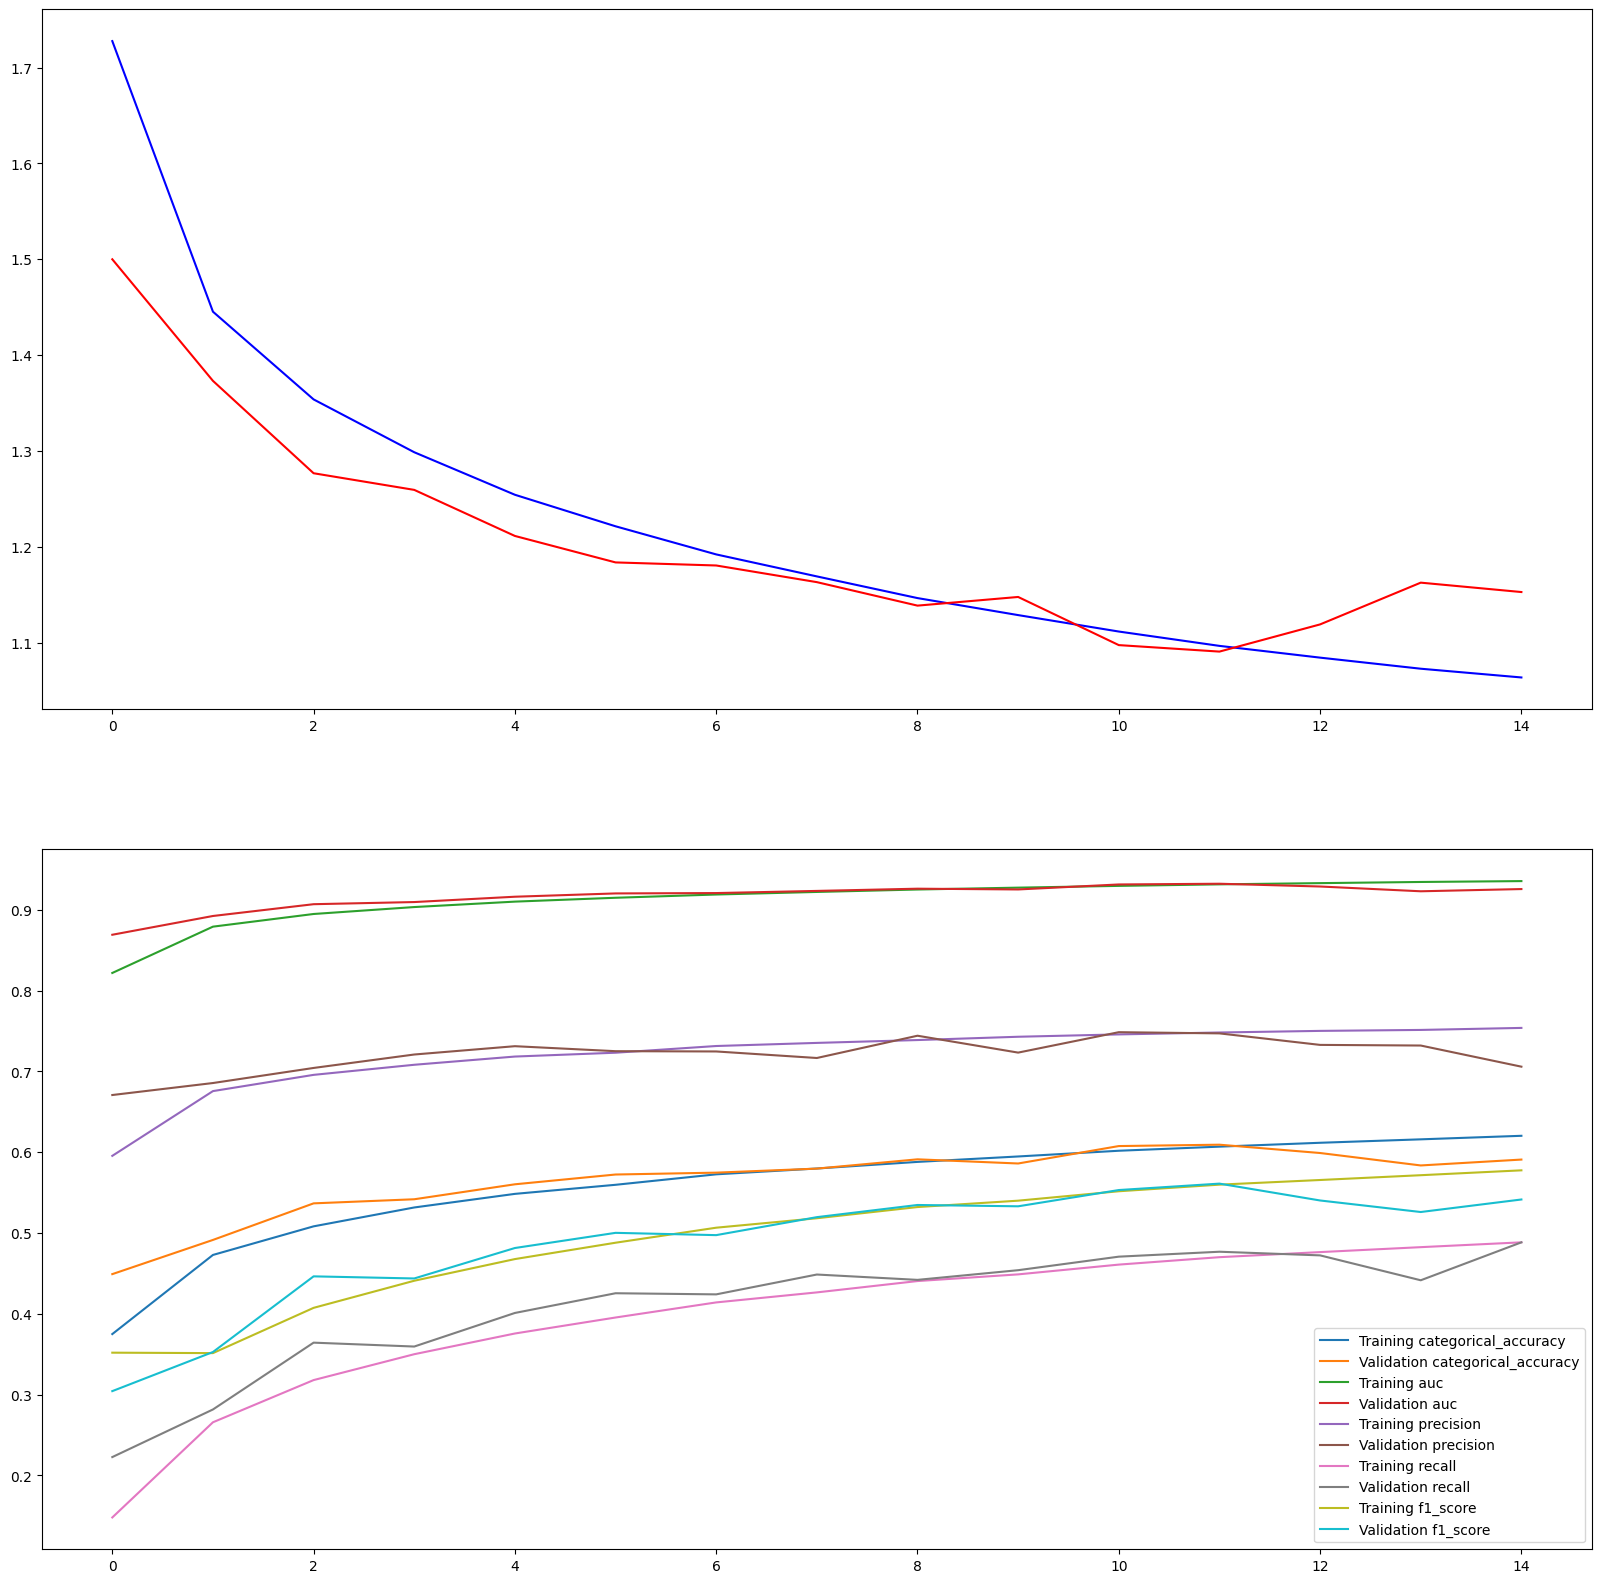

In [75]:
show_training_validation_loss_and_metrics(model22,metrics2)

In [76]:
model22.evaluate(test_it)

5625/5625 [==============================] - 60s 11ms/step - loss: 1.1629 - categorical_accuracy: 0.5882 - auc: 0.9244 - precision: 0.7019 - recall: 0.4874 - f1_score: 0.5401


[1.1629278659820557,
 0.5881555676460266,
 0.9243577718734741,
 0.7018638253211975,
 0.4874444305896759,
 0.5400830507278442]

5625/5625 [==============================] - 17s 3ms/step


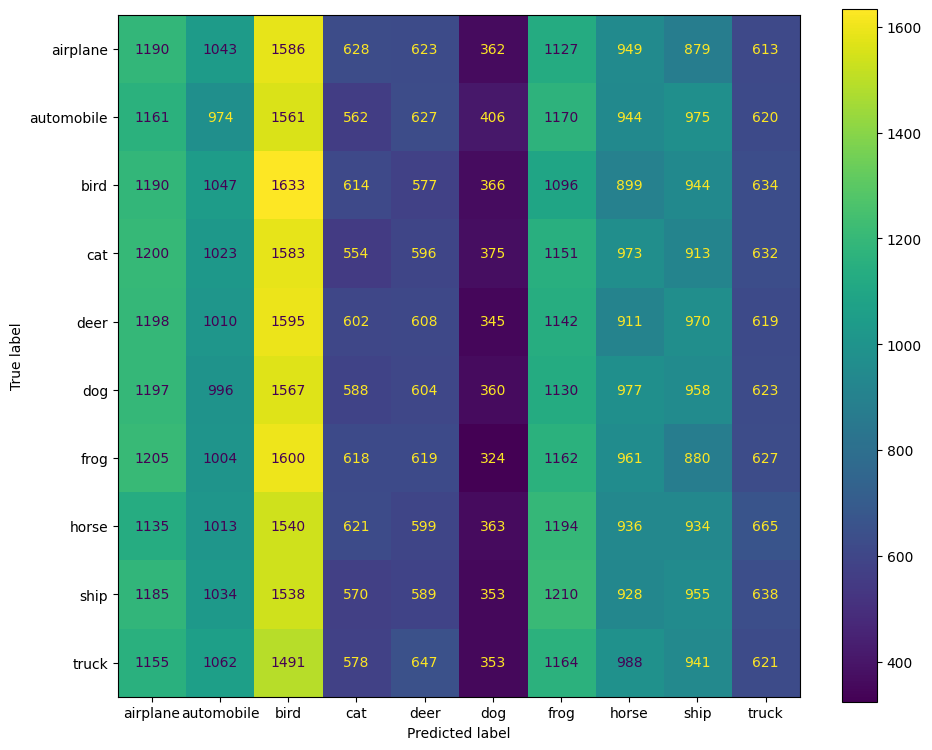

In [77]:
show_confusion_matrix(model22,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


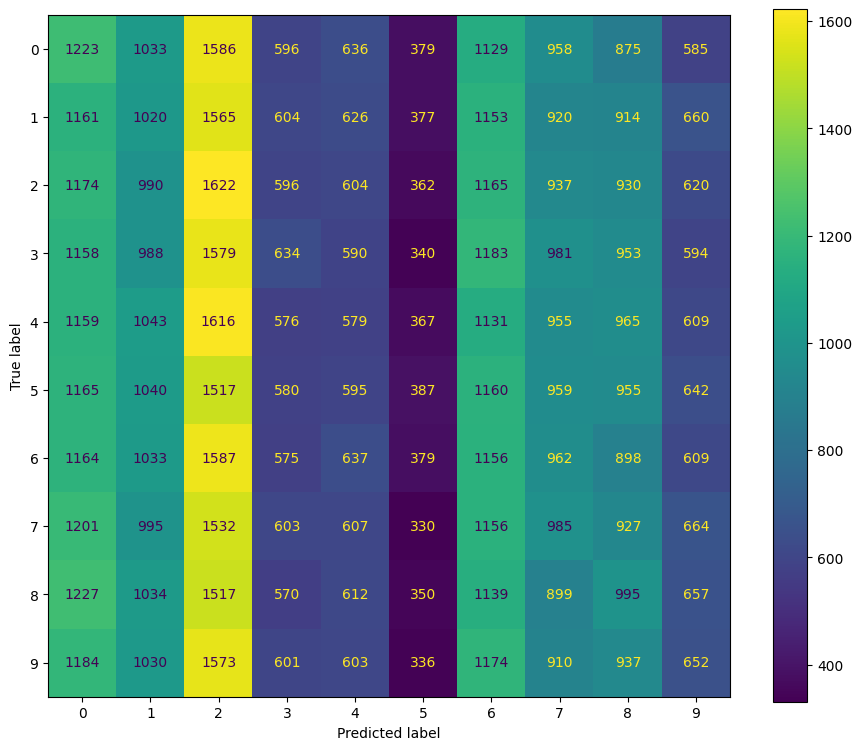

In [78]:
show_confusion_matrix_without_names(model22,test_ds,num_classes)

# Architektura trzeciego modelu

In [79]:
model32 = create_model3(num_classes)

model32.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [80]:
model32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 layer_normalization_22 (Lay  (None, 32, 32, 256)      512       
 erNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 layer_normalization_23 (Lay  (None, 16, 16, 128)      256       
 erNormalization)                                                
                                                      

In [81]:
history = model32.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.6787 - categorical_accuracy: 0.3683 - auc: 0.8307 - precision: 0.6319 - recall: 0.1309 - f1_score: 0.3984 - val_loss: 1.4610 - val_categorical_accuracy: 0.4570 - val_auc: 0.8765 - val_precision: 0.6619 - val_recall: 0.2433 - val_f1_score: 0.3098
Epoch 2/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.4141 - categorical_accuracy: 0.4795 - auc: 0.8848 - precision: 0.6792 - recall: 0.2739 - f1_score: 0.3532 - val_loss: 1.3170 - val_categorical_accuracy: 0.5158 - val_auc: 0.9009 - val_precision: 0.7037 - val_recall: 0.3290 - val_f1_score: 0.4002
Epoch 3/20
5625/5625 [==============================] - 150s 27ms/step - loss: 1.3075 - categorical_accuracy: 0.5208 - auc: 0.9023 - precision: 0.6997 - recall: 0.3380 - f1_score: 0.4221 - val_loss: 1.2782 - val_categorical_accuracy: 0.5324 - val_auc: 0.9076 - val_precision: 0.6724 - val_recall: 0.3921 - val_f1_score: 0.4419
Epoch 4/20
5625/562

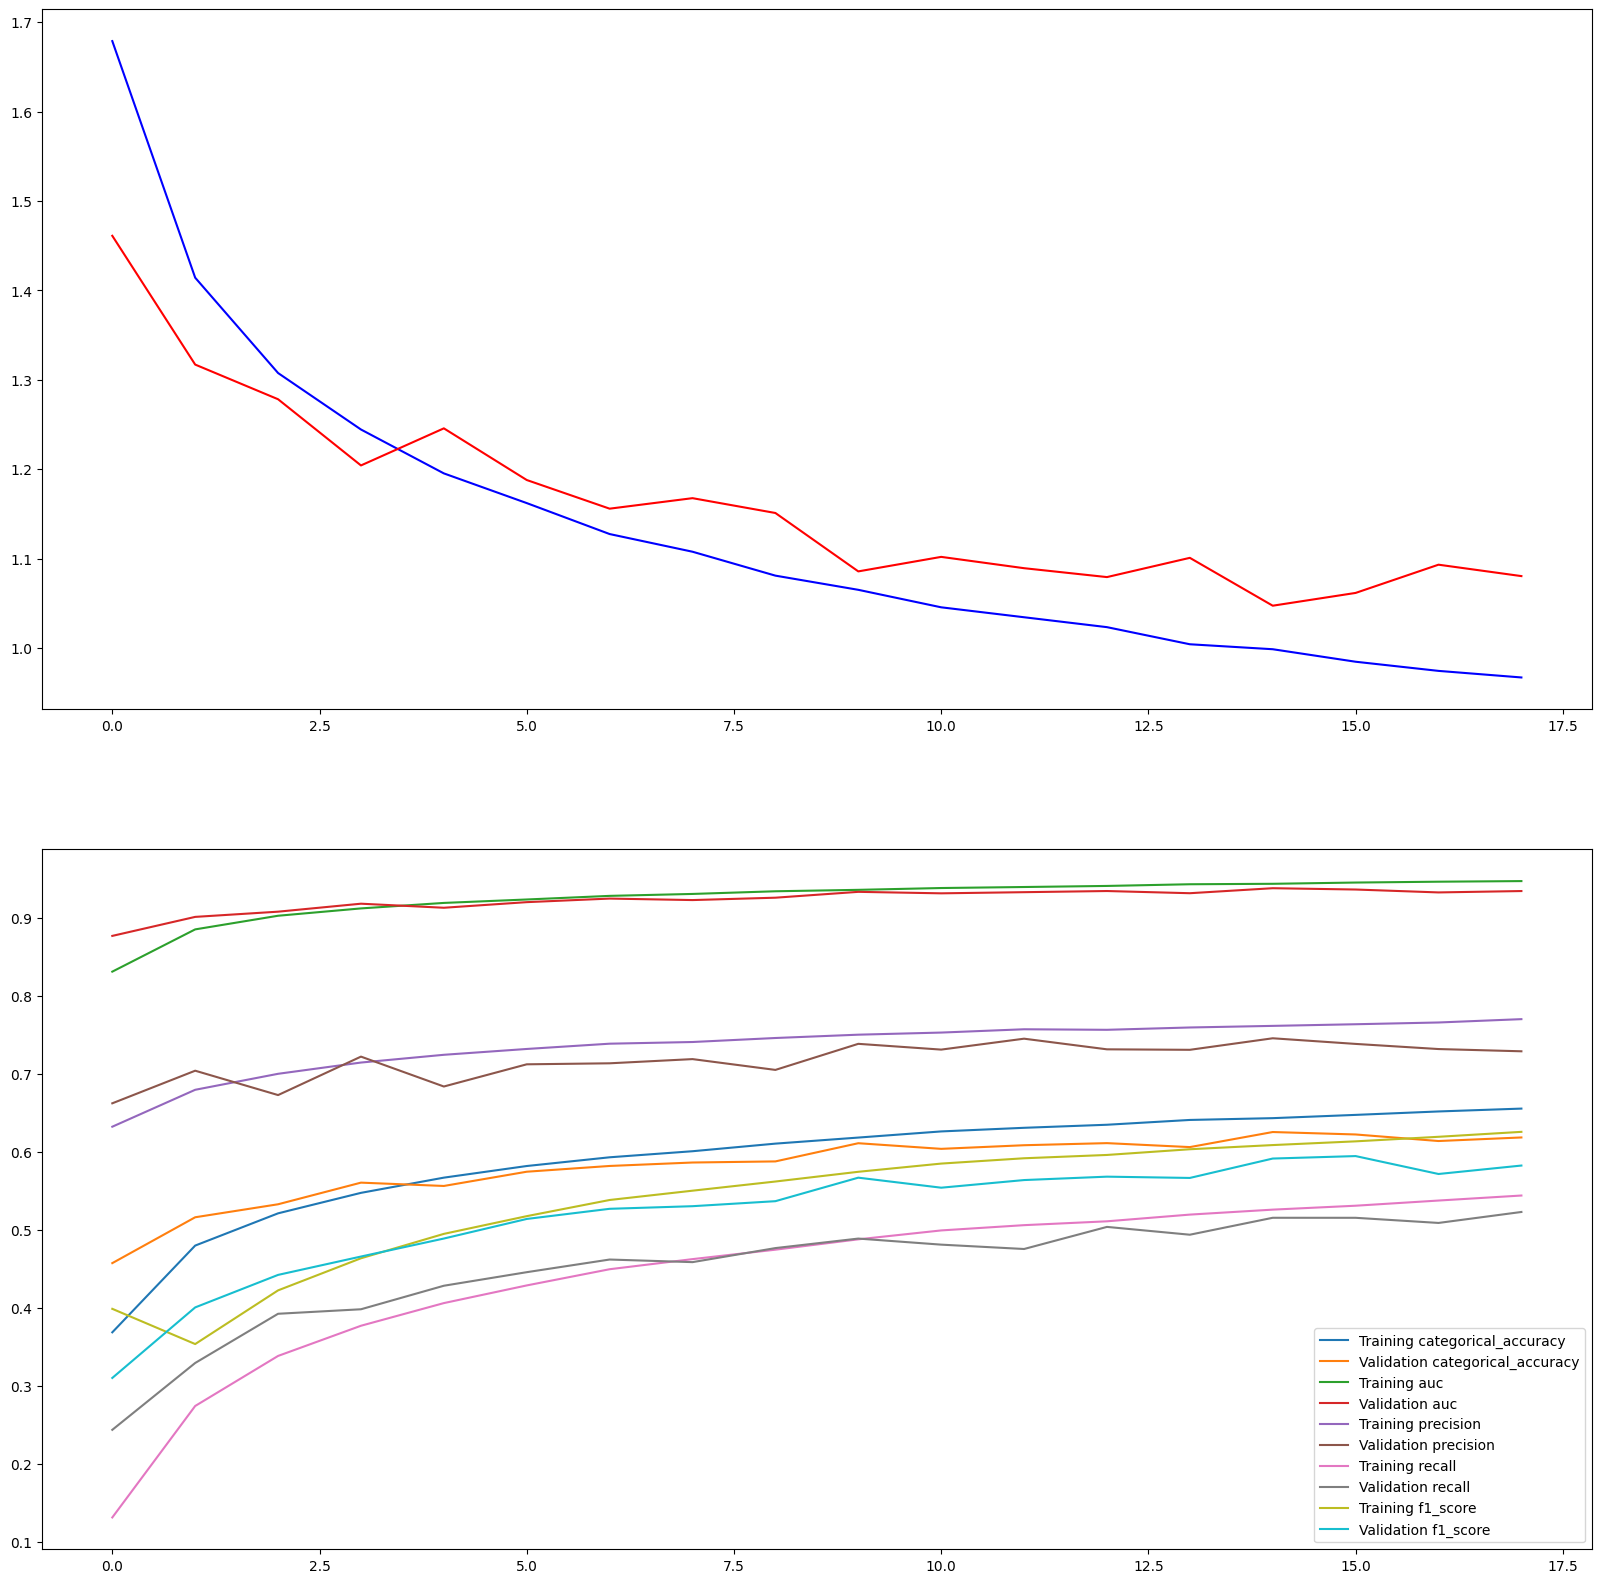

In [82]:
show_training_validation_loss_and_metrics(model32,metrics2)

In [83]:
model32.evaluate(test_it)

5625/5625 [==============================] - 63s 11ms/step - loss: 1.0903 - categorical_accuracy: 0.6145 - auc: 0.9329 - precision: 0.7249 - recall: 0.5189 - f1_score: 0.5789


[1.090272068977356,
 0.6145333051681519,
 0.9329066872596741,
 0.7248963713645935,
 0.5188888907432556,
 0.5789037942886353]

5625/5625 [==============================] - 17s 3ms/step


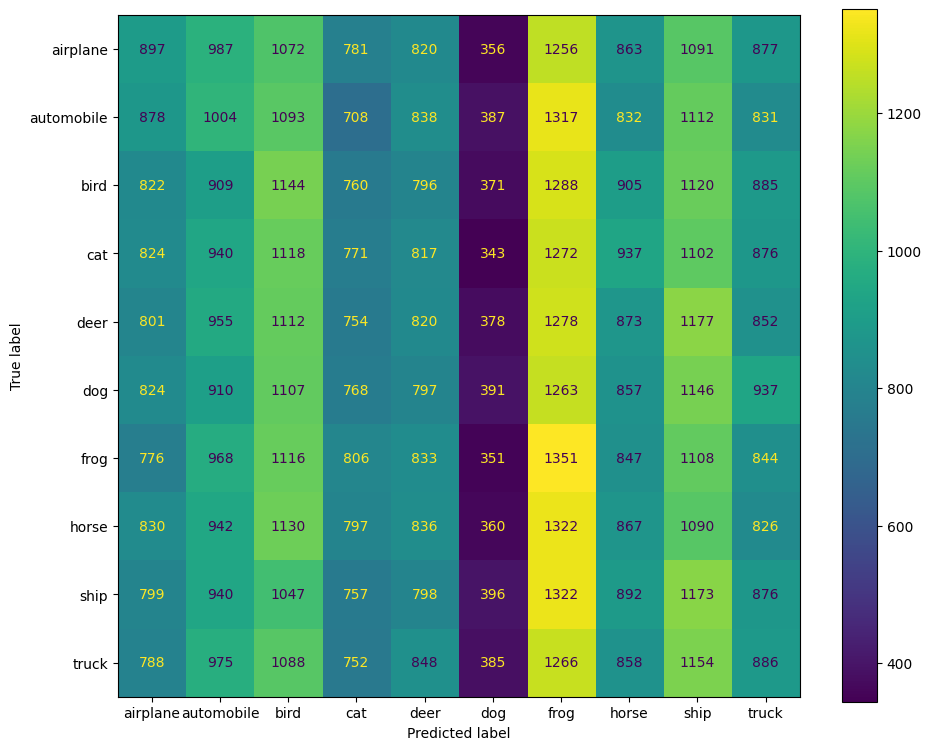

In [84]:
show_confusion_matrix(model32,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


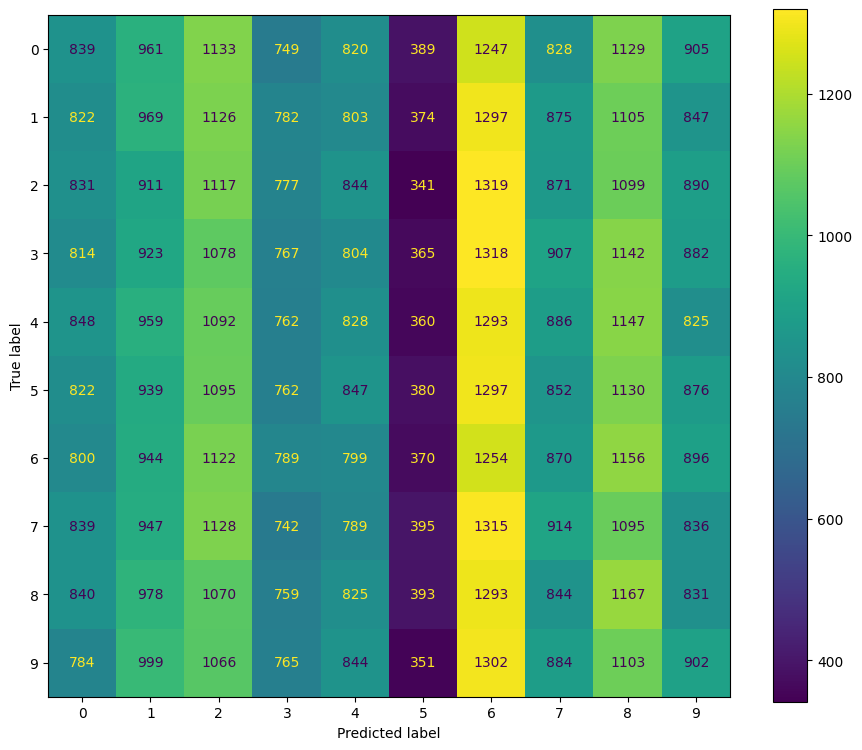

In [85]:
show_confusion_matrix_without_names(model32,test_ds,num_classes)

# Ziarno 7654

In [86]:
SEED = 7654

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [87]:
model13 = create_model1(num_classes)

In [88]:
model13.compile( 
    loss=loss_func,
    metrics=metrics
)

In [89]:

model13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                      

In [90]:
history = model13.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.5781 - categorical_accuracy: 0.4326 - auc: 0.8561 - precision: 0.6070 - recall: 0.2469 - f1_score: 0.4675 - val_loss: 1.4688 - val_categorical_accuracy: 0.4690 - val_auc: 0.8758 - val_precision: 0.6558 - val_recall: 0.2865 - val_f1_score: 0.3705
Epoch 2/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.2740 - categorical_accuracy: 0.5396 - auc: 0.9074 - precision: 0.7043 - recall: 0.3751 - f1_score: 0.4655 - val_loss: 1.2937 - val_categorical_accuracy: 0.5348 - val_auc: 0.9061 - val_precision: 0.6675 - val_recall: 0.4104 - val_f1_score: 0.4598
Epoch 3/20
5625/5625 [==============================] - 160s 28ms/step - loss: 1.1793 - categorical_accuracy: 0.5770 - auc: 0.9208 - precision: 0.7241 - recall: 0.4277 - f1_score: 0.5178 - val_loss: 1.1962 - val_categorical_accuracy: 0.5723 - val_auc: 0.9191 - val_precision: 0.7079 - val_recall: 0.4402 - val_f1_score: 0.5023
Epoch 4/20
5625/562

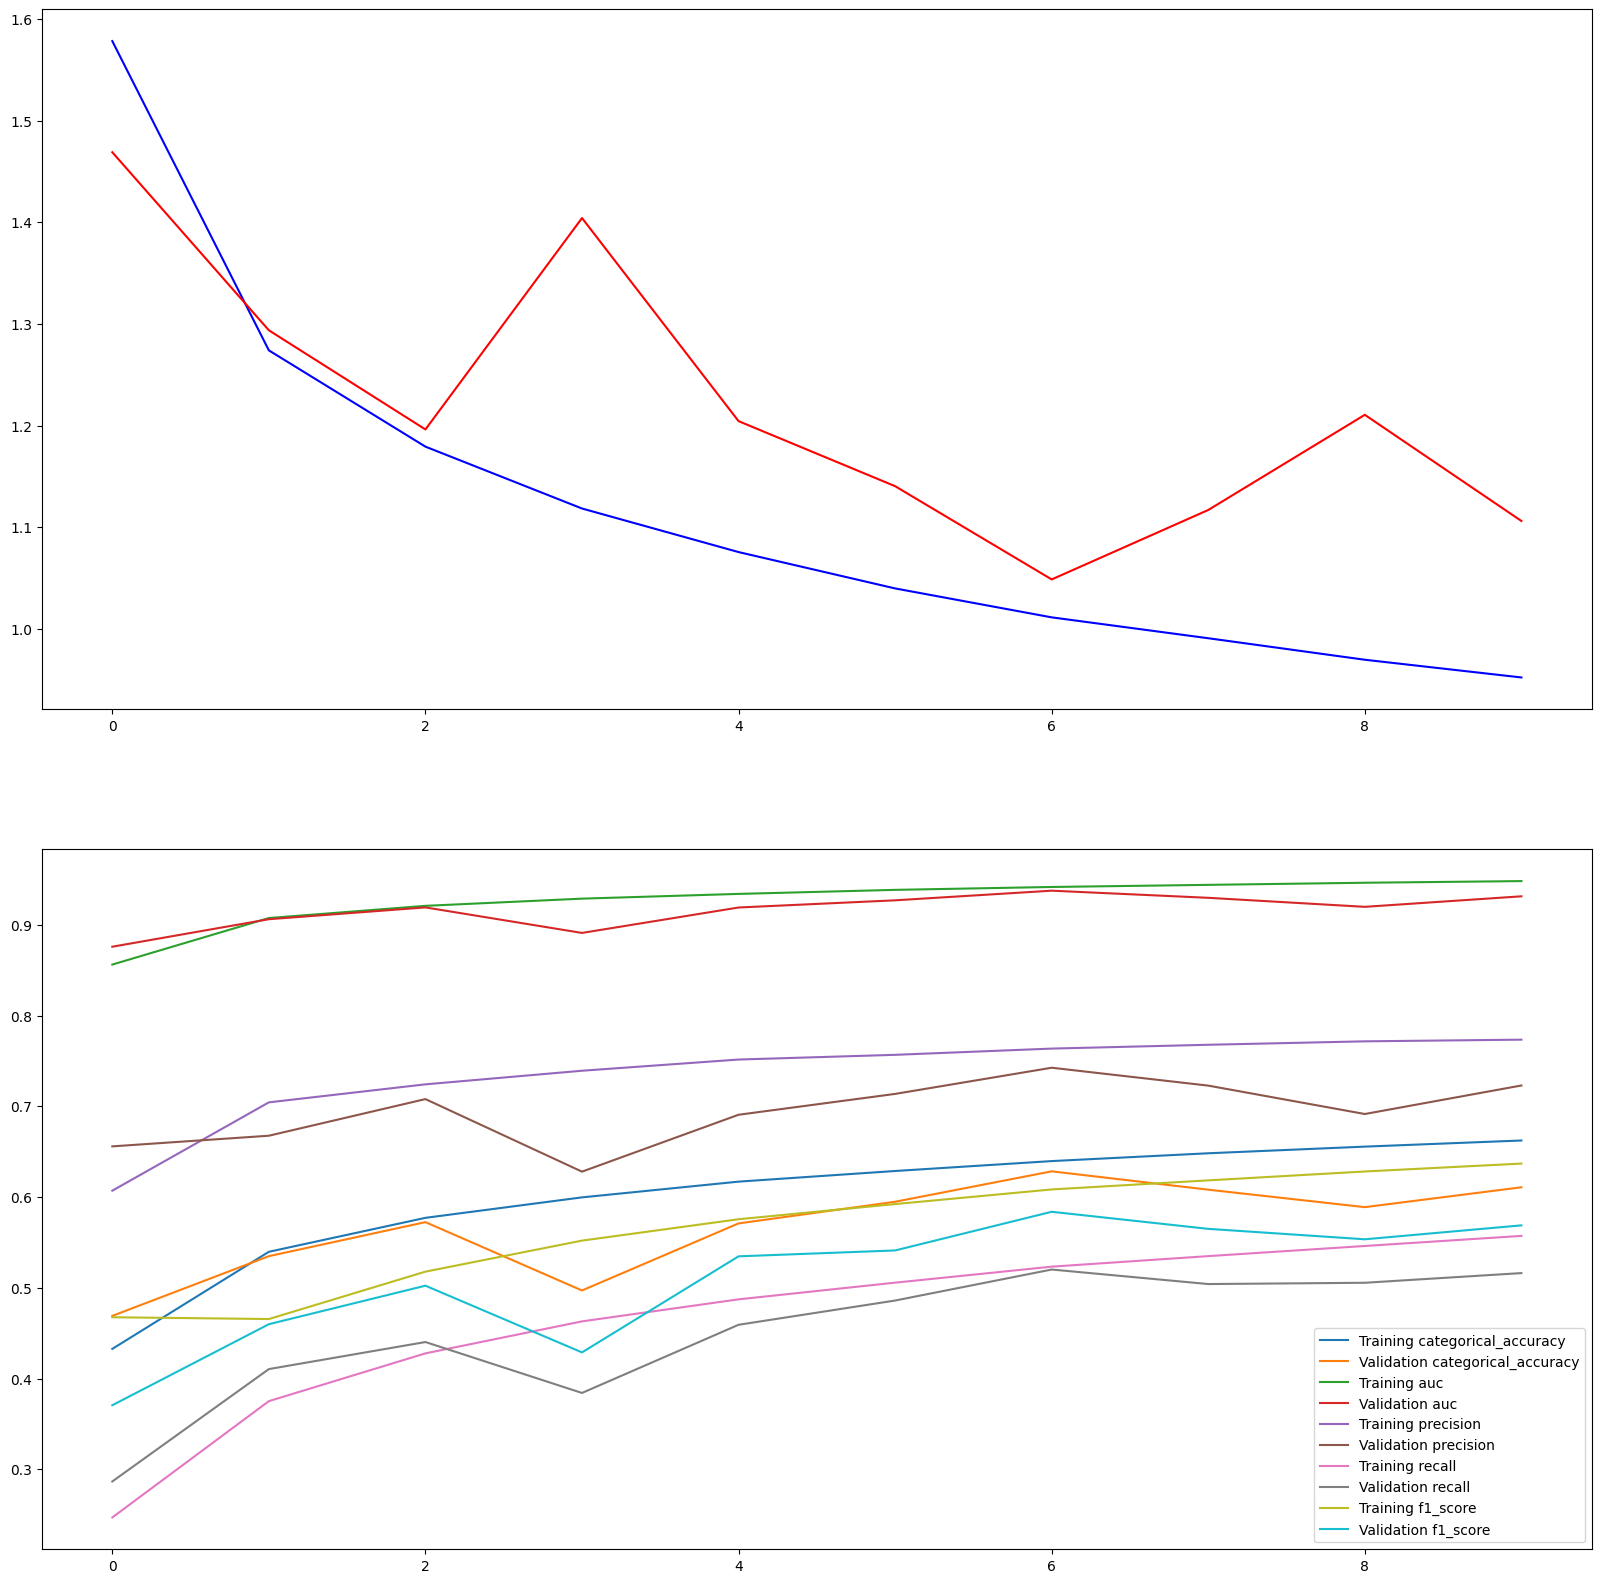

In [91]:
show_training_validation_loss_and_metrics(model13,metrics2)

In [92]:
model13.evaluate(test_it)

5625/5625 [==============================] - 59s 10ms/step - loss: 1.1154 - categorical_accuracy: 0.6091 - auc: 0.9301 - precision: 0.7205 - recall: 0.5145 - f1_score: 0.5669


[1.1153993606567383,
 0.6090999841690063,
 0.9301405549049377,
 0.7205408811569214,
 0.5145221948623657,
 0.566897988319397]

5625/5625 [==============================] - 15s 3ms/step


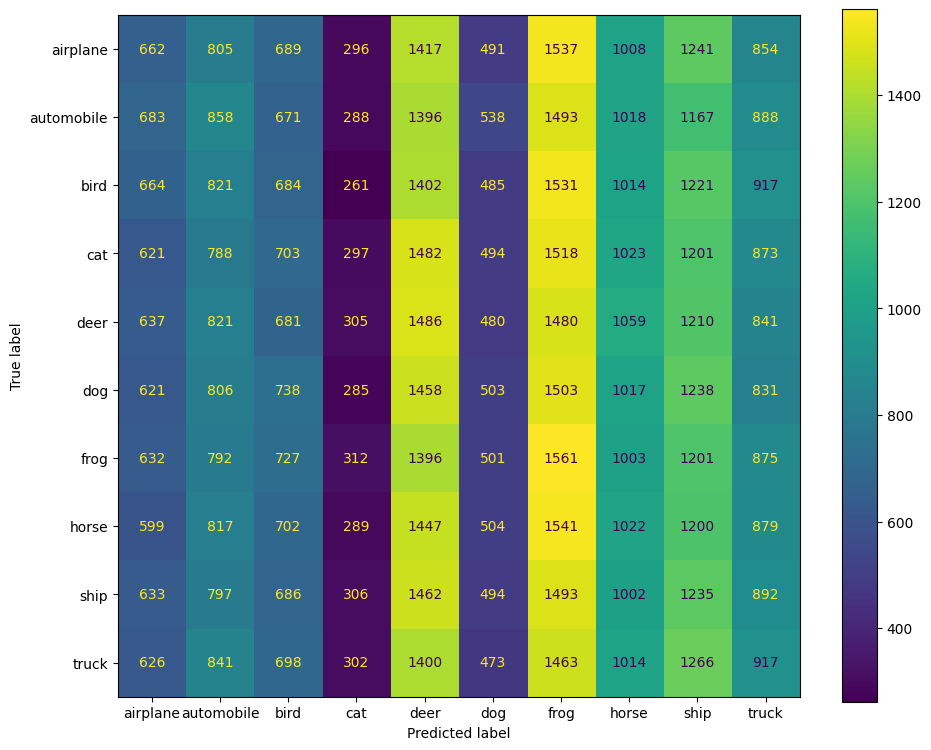

In [93]:
show_confusion_matrix(model13,test_ds,num_classes,class_names)

5625/5625 [==============================] - 13s 2ms/step


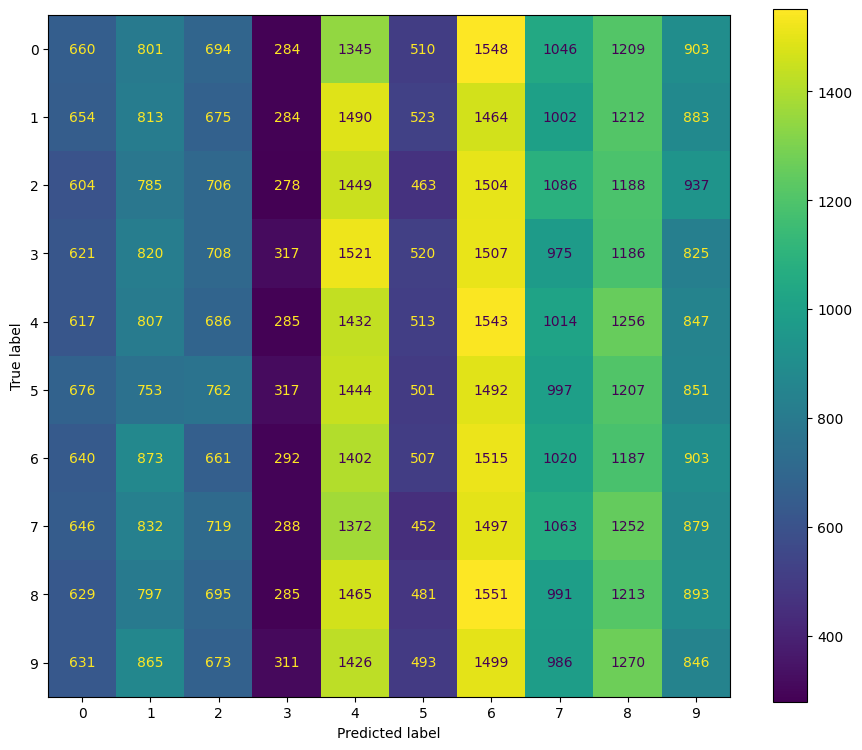

In [94]:
show_confusion_matrix_without_names(model13,test_ds,num_classes)

# Architektura drugiego modelu

In [95]:
model23 = create_model2(num_classes)

In [96]:
model23.compile( 
    loss=loss_func,
    metrics=metrics
)

In [97]:
model23.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_27 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_9 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_28 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [98]:
history = model23.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 151s 27ms/step - loss: 1.7216 - categorical_accuracy: 0.3754 - auc: 0.8234 - precision: 0.6006 - recall: 0.1490 - f1_score: 0.4234 - val_loss: 1.5489 - val_categorical_accuracy: 0.4347 - val_auc: 0.8625 - val_precision: 0.5969 - val_recall: 0.2759 - val_f1_score: 0.3207
Epoch 2/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.4274 - categorical_accuracy: 0.4808 - auc: 0.8824 - precision: 0.6785 - recall: 0.2748 - f1_score: 0.3619 - val_loss: 1.3729 - val_categorical_accuracy: 0.5048 - val_auc: 0.8921 - val_precision: 0.6728 - val_recall: 0.3431 - val_f1_score: 0.4119
Epoch 3/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.3388 - categorical_accuracy: 0.5161 - auc: 0.8972 - precision: 0.6980 - recall: 0.3270 - f1_score: 0.4173 - val_loss: 1.3167 - val_categorical_accuracy: 0.5312 - val_auc: 0.9004 - val_precision: 0.7048 - val_recall: 0.3619 - val_f1_score: 0.4397
Epoch 4/20
5625/5625 [========

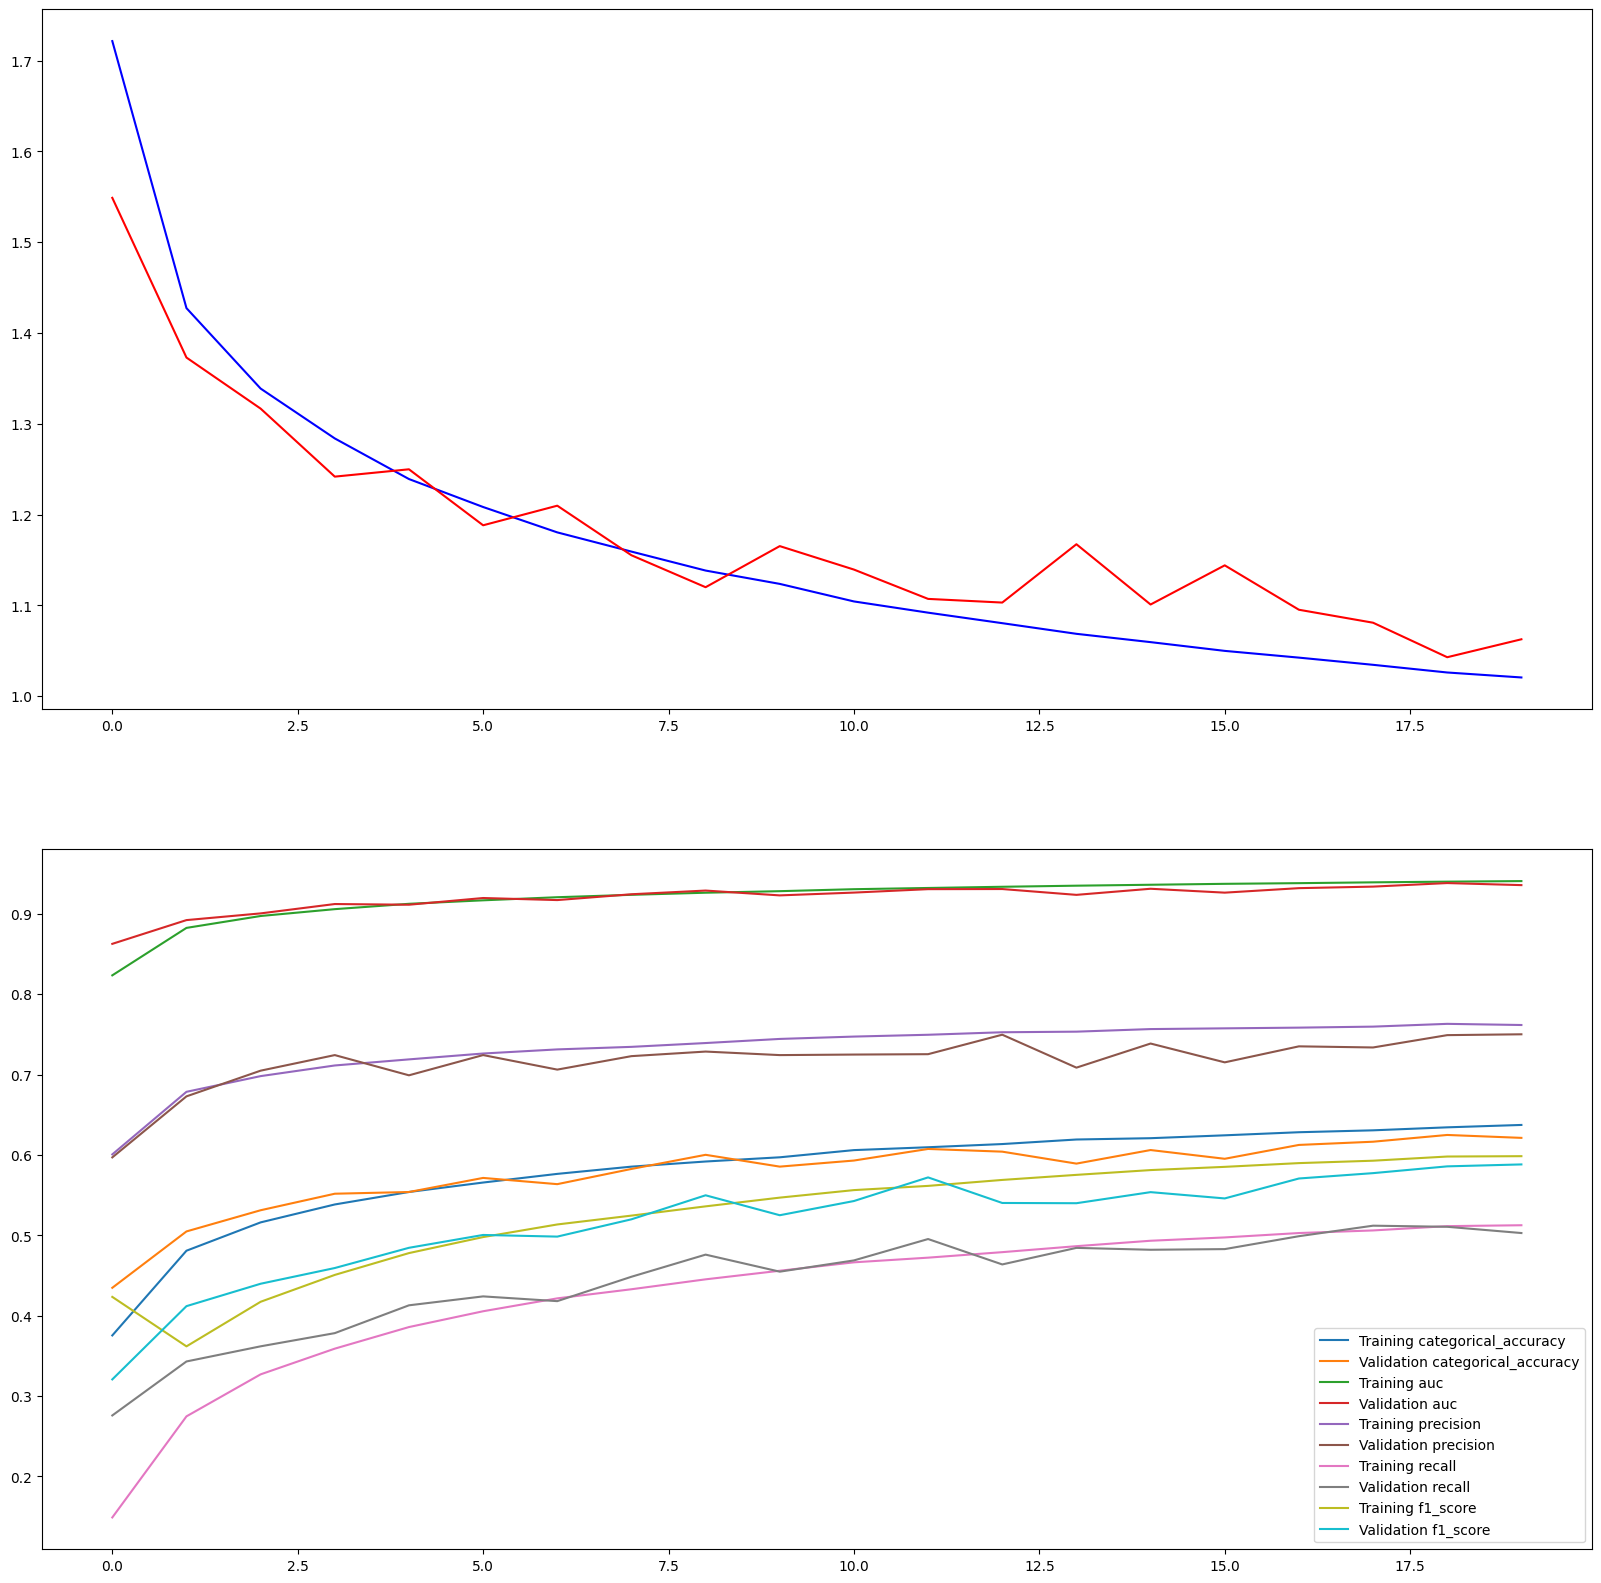

In [99]:
show_training_validation_loss_and_metrics(model23,metrics2)

In [100]:
model23.evaluate(test_it)

5625/5625 [==============================] - 87s 15ms/step - loss: 1.0738 - categorical_accuracy: 0.6203 - auc: 0.9342 - precision: 0.7466 - recall: 0.5016 - f1_score: 0.5866


[1.0738223791122437,
 0.6202777624130249,
 0.9342148303985596,
 0.7465893030166626,
 0.50163334608078,
 0.5865510702133179]

5625/5625 [==============================] - 18s 3ms/step


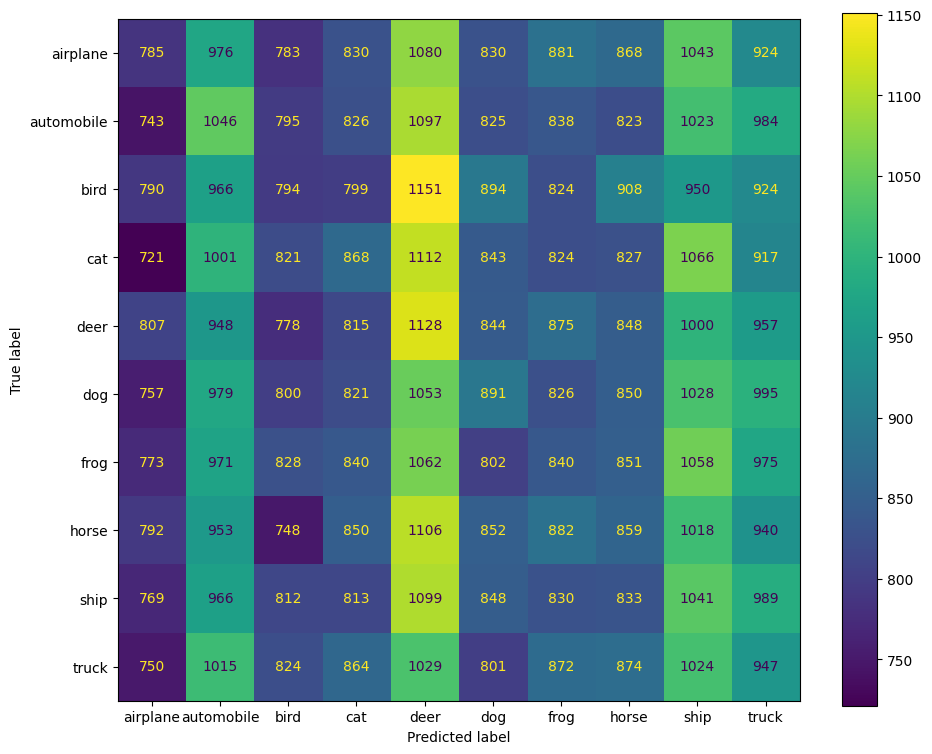

In [101]:
show_confusion_matrix(model23,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


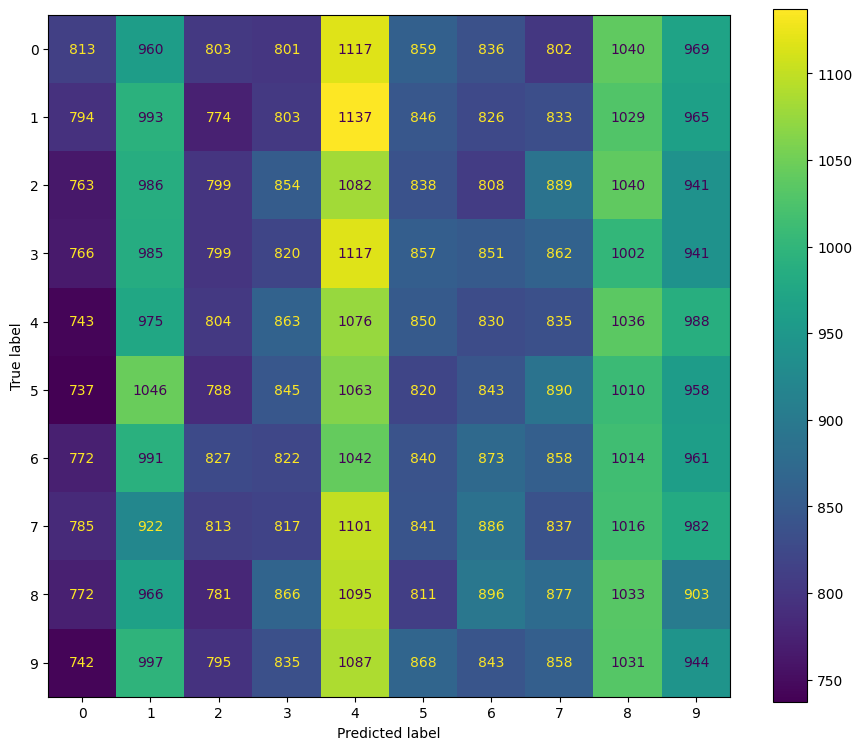

In [102]:
show_confusion_matrix_without_names(model23,test_ds,num_classes)

# Architektura trzeciego modelu

In [103]:
model33 = create_model3(num_classes)

model33.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [104]:
history = model33.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 152s 27ms/step - loss: 1.6973 - categorical_accuracy: 0.3626 - auc: 0.8258 - precision: 0.6216 - recall: 0.1247 - f1_score: 0.4213 - val_loss: 1.5136 - val_categorical_accuracy: 0.4317 - val_auc: 0.8677 - val_precision: 0.6070 - val_recall: 0.2625 - val_f1_score: 0.3082
Epoch 2/20
5625/5625 [==============================] - 151s 27ms/step - loss: 1.4245 - categorical_accuracy: 0.4722 - auc: 0.8831 - precision: 0.6726 - recall: 0.2680 - f1_score: 0.3474 - val_loss: 1.3446 - val_categorical_accuracy: 0.5044 - val_auc: 0.8968 - val_precision: 0.6800 - val_recall: 0.3177 - val_f1_score: 0.3863
Epoch 3/20
5625/5625 [==============================] - 154s 27ms/step - loss: 1.3201 - categorical_accuracy: 0.5165 - auc: 0.9004 - precision: 0.6994 - recall: 0.3320 - f1_score: 0.4168 - val_loss: 1.2522 - val_categorical_accuracy: 0.5404 - val_auc: 0.9109 - val_precision: 0.7062 - val_recall: 0.3792 - val_f1_score: 0.4528
Epoch 4/20
5625/562

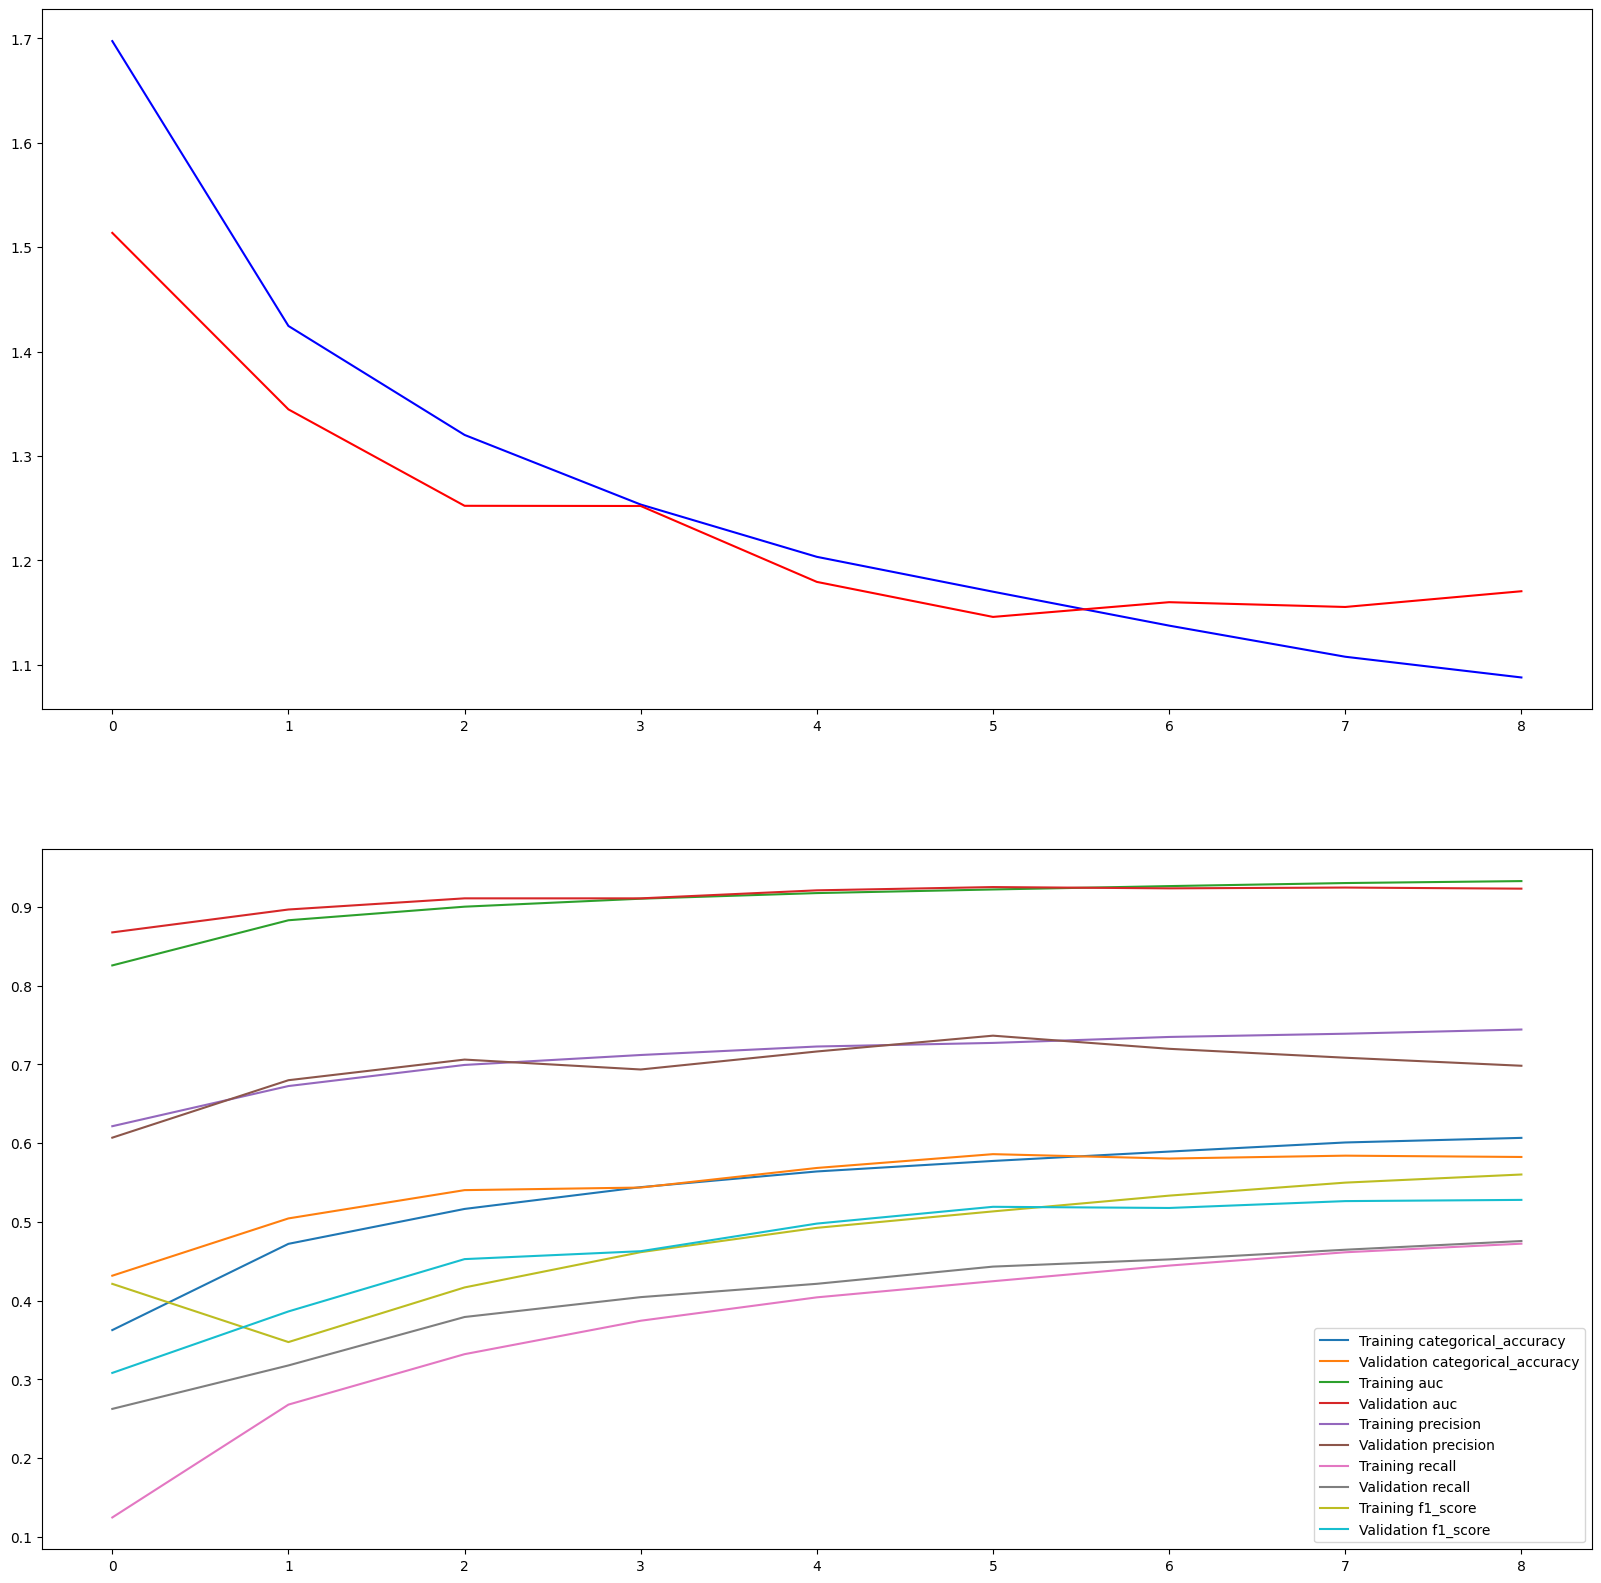

In [105]:
show_training_validation_loss_and_metrics(model33,metrics2)

In [106]:
model33.evaluate(test_it)

5625/5625 [==============================] - 61s 11ms/step - loss: 1.1791 - categorical_accuracy: 0.5803 - auc: 0.9220 - precision: 0.6976 - recall: 0.4747 - f1_score: 0.5281


[1.1791120767593384,
 0.580299973487854,
 0.9220461249351501,
 0.6975817680358887,
 0.47468888759613037,
 0.5280859470367432]

5625/5625 [==============================] - 17s 3ms/step


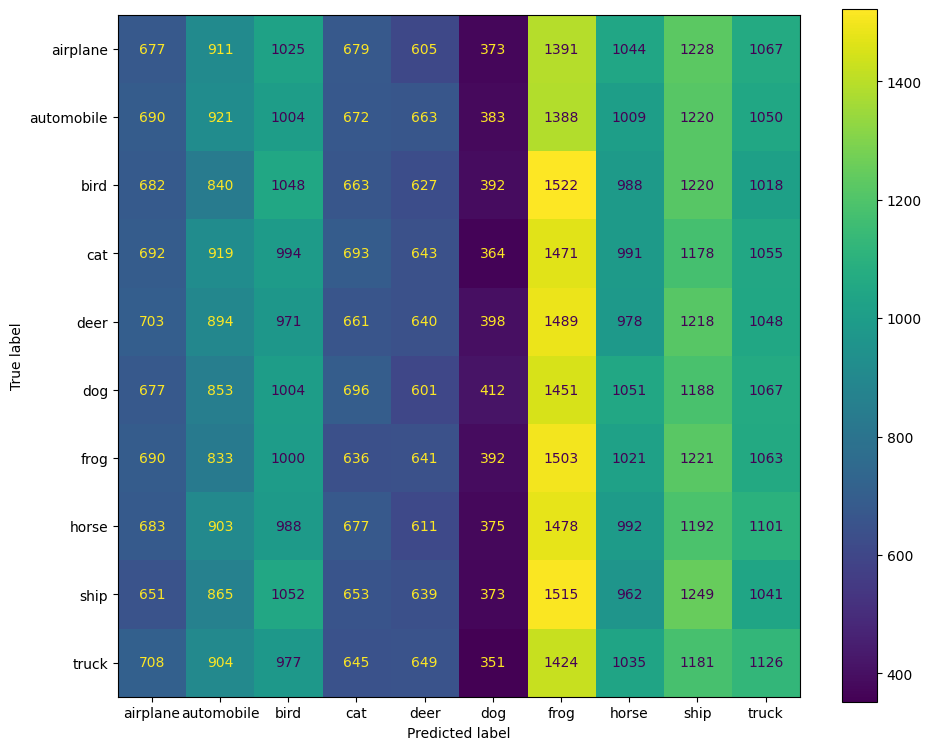

In [107]:
show_confusion_matrix(model33,test_ds,num_classes,class_names)

5625/5625 [==============================] - 16s 3ms/step


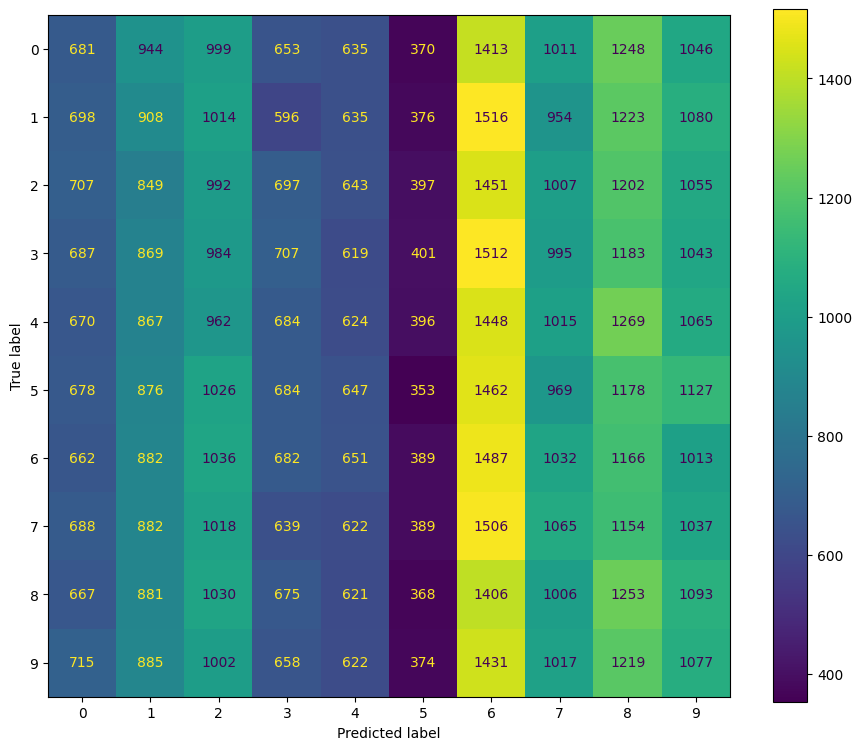

In [108]:
show_confusion_matrix_without_names(model33,test_ds,num_classes)

# Ziarno 313

In [109]:
SEED = 313
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [110]:
model14 = create_model1(num_classes)

In [111]:
model14.compile( 
    loss=loss_func,
    metrics=metrics
)

In [112]:
model14.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [113]:
history = model14.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.5775 - categorical_accuracy: 0.4314 - auc: 0.8562 - precision: 0.6023 - recall: 0.2447 - f1_score: 0.4373 - val_loss: 1.3900 - val_categorical_accuracy: 0.5013 - val_auc: 0.8894 - val_precision: 0.6649 - val_recall: 0.3477 - val_f1_score: 0.4089
Epoch 2/20
5625/5625 [==============================] - 150s 27ms/step - loss: 1.2736 - categorical_accuracy: 0.5416 - auc: 0.9073 - precision: 0.7048 - recall: 0.3783 - f1_score: 0.4681 - val_loss: 1.6878 - val_categorical_accuracy: 0.4411 - val_auc: 0.8476 - val_precision: 0.5864 - val_recall: 0.3377 - val_f1_score: 0.3607
Epoch 3/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.1734 - categorical_accuracy: 0.5794 - auc: 0.9215 - precision: 0.7287 - recall: 0.4340 - f1_score: 0.5248 - val_loss: 1.1874 - val_categorical_accuracy: 0.5743 - val_auc: 0.9203 - val_precision: 0.7089 - val_recall: 0.4451 - val_f1_score: 0.5108
Epoch 4/20
5625/562

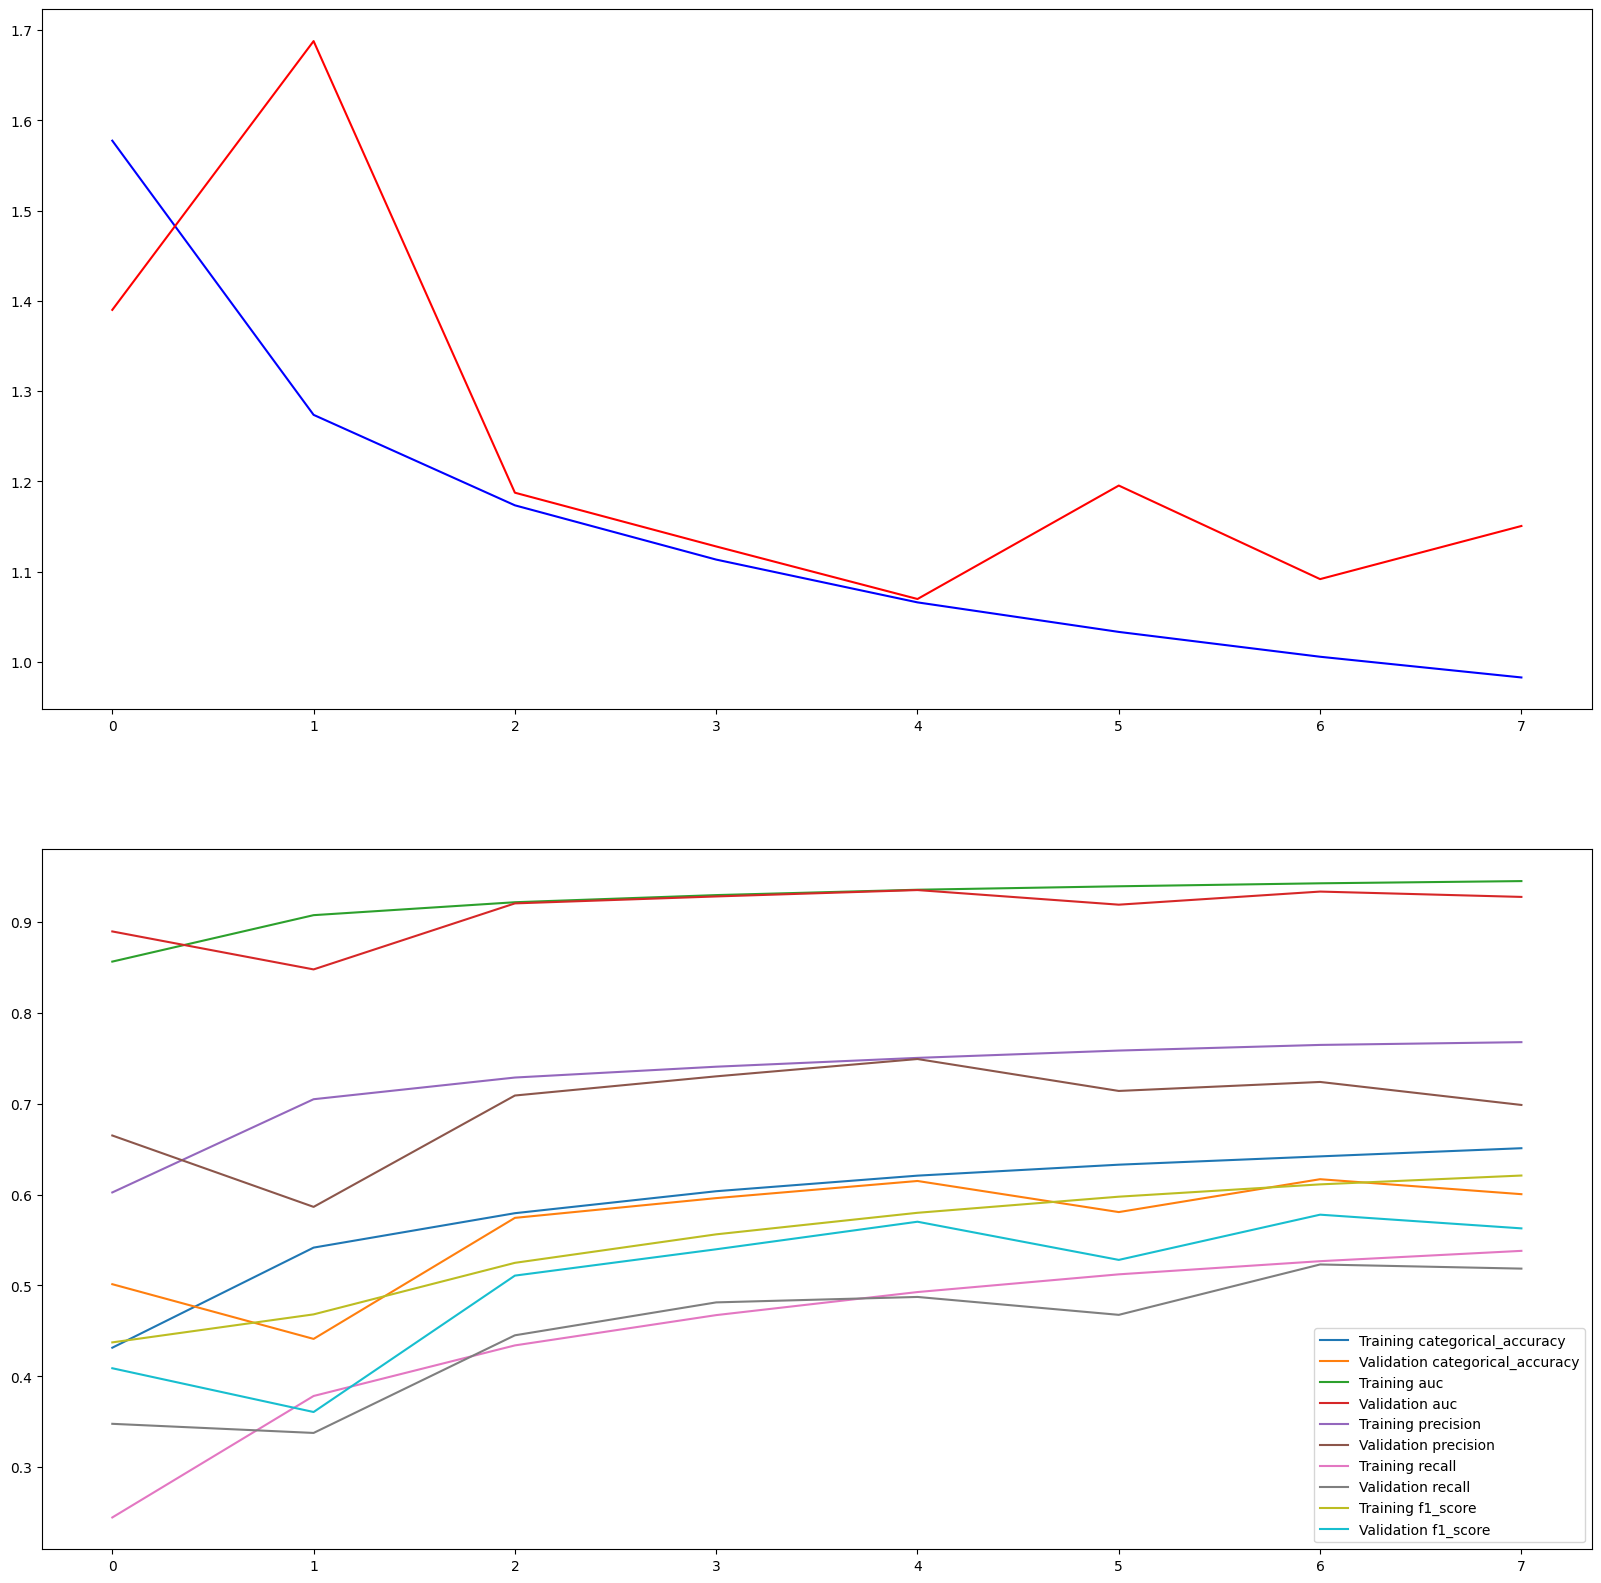

In [114]:
show_training_validation_loss_and_metrics(model14,metrics2)

In [115]:
model14.evaluate(test_it)

5625/5625 [==============================] - 60s 11ms/step - loss: 1.1607 - categorical_accuracy: 0.5999 - auc: 0.9264 - precision: 0.6949 - recall: 0.5173 - f1_score: 0.5612


[1.1607232093811035,
 0.5998777747154236,
 0.9263630509376526,
 0.6948884129524231,
 0.5173444151878357,
 0.5612472295761108]

5625/5625 [==============================] - 15s 3ms/step


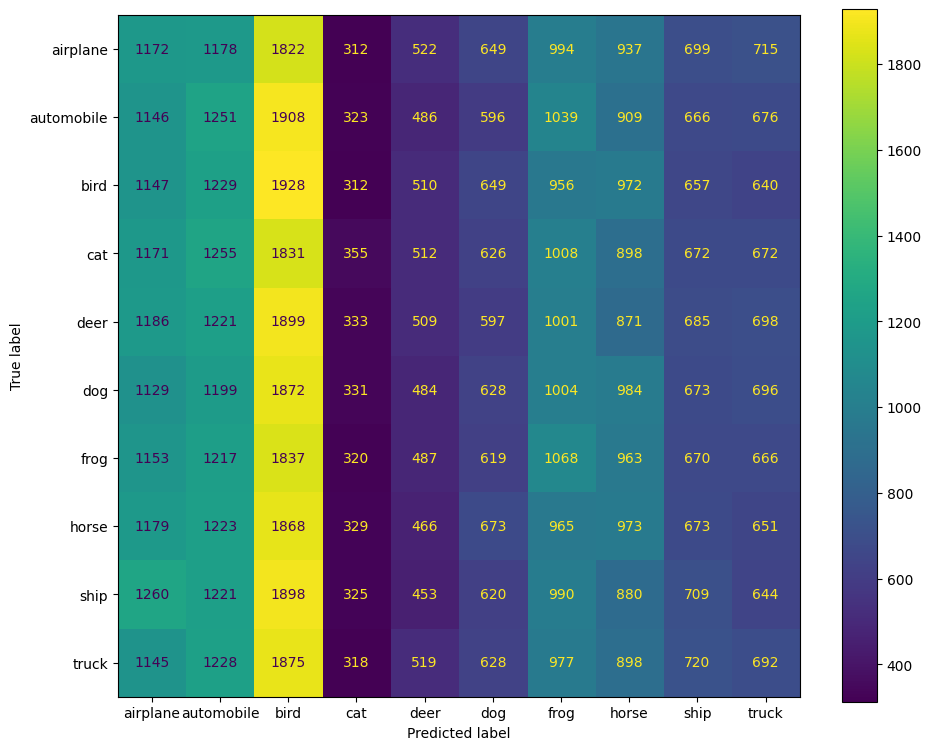

In [116]:
show_confusion_matrix(model14,test_ds,num_classes,class_names)

5625/5625 [==============================] - 15s 3ms/step


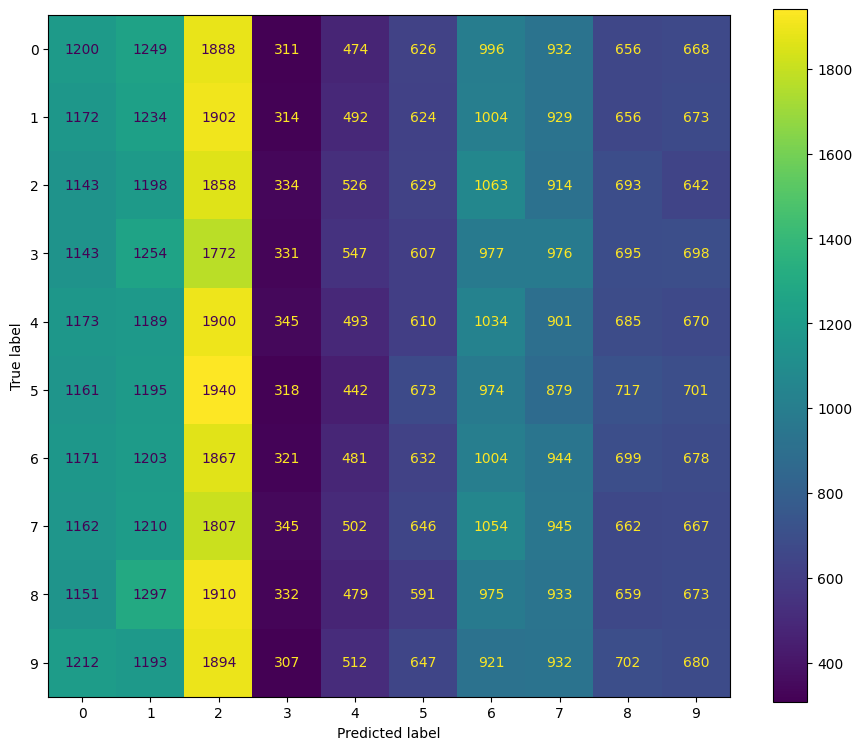

In [117]:
show_confusion_matrix_without_names(model14,test_ds,num_classes)

# Architektura drugiego modelu

In [118]:
model24 = create_model2(num_classes)

In [119]:
model24.compile( 
    loss=loss_func,
    metrics=metrics
)

In [120]:
model24.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_36 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 75)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_37 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [121]:
history = model24.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.7292 - categorical_accuracy: 0.3739 - auc: 0.8211 - precision: 0.6021 - recall: 0.1461 - f1_score: 0.4188 - val_loss: 1.6300 - val_categorical_accuracy: 0.4075 - val_auc: 0.8429 - val_precision: 0.6024 - val_recall: 0.1948 - val_f1_score: 0.2497
Epoch 2/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.4353 - categorical_accuracy: 0.4786 - auc: 0.8810 - precision: 0.6754 - recall: 0.2713 - f1_score: 0.3581 - val_loss: 1.4767 - val_categorical_accuracy: 0.4695 - val_auc: 0.8770 - val_precision: 0.6089 - val_recall: 0.3171 - val_f1_score: 0.3679
Epoch 3/20
5625/5625 [==============================] - 148s 26ms/step - loss: 1.3425 - categorical_accuracy: 0.5136 - auc: 0.8966 - precision: 0.6954 - recall: 0.3258 - f1_score: 0.4157 - val_loss: 1.3375 - val_categorical_accuracy: 0.5239 - val_auc: 0.8978 - val_precision: 0.6817 - val_recall: 0.3716 - val_f1_score: 0.4404
Epoch 4/20
5625/562

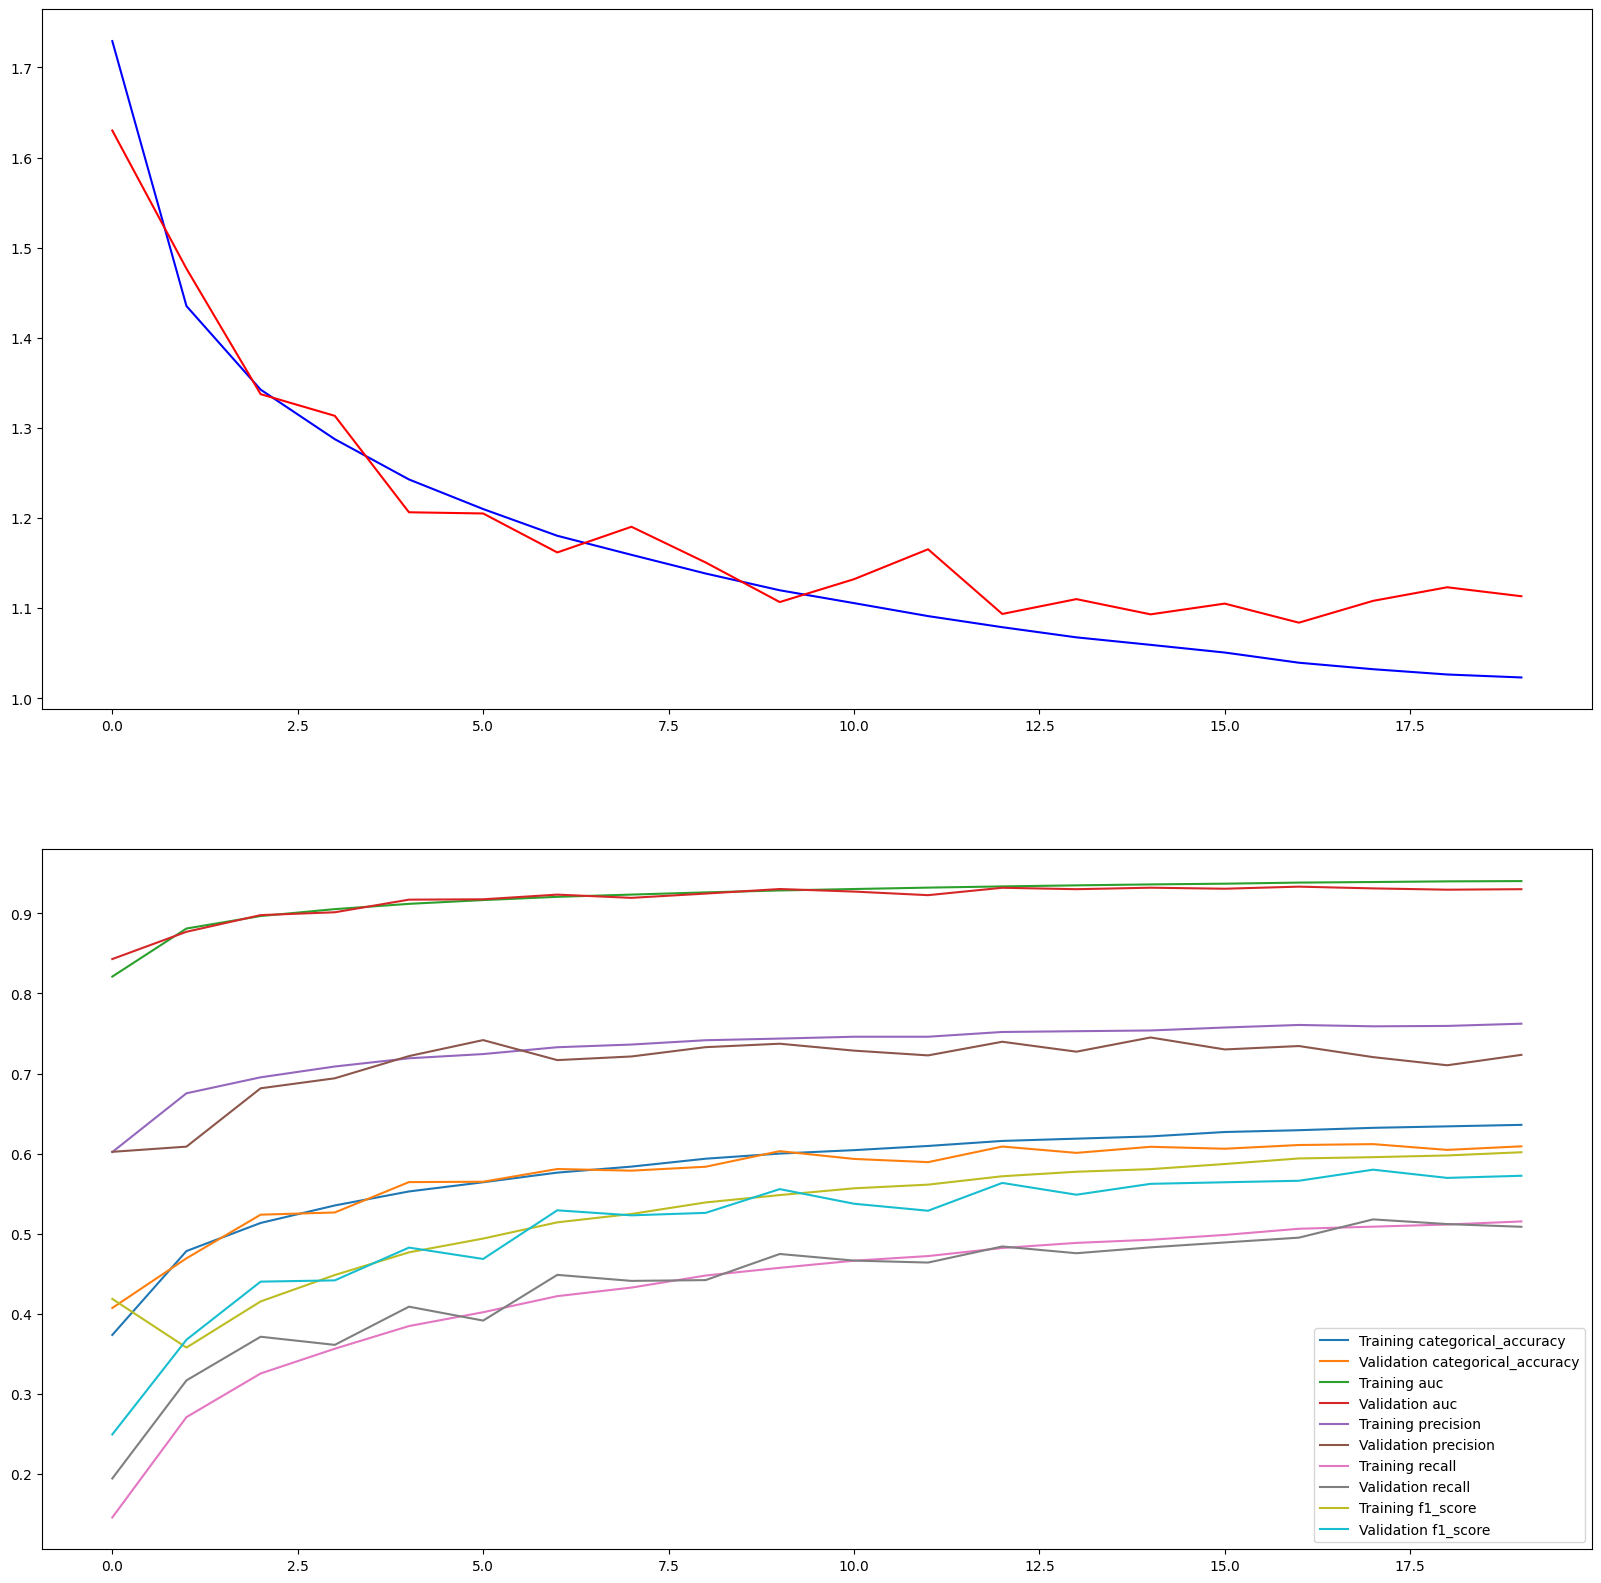

In [122]:
show_training_validation_loss_and_metrics(model24,metrics2)

In [123]:
model24.evaluate(test_it)

5625/5625 [==============================] - 61s 11ms/step - loss: 1.1222 - categorical_accuracy: 0.6096 - auc: 0.9290 - precision: 0.7222 - recall: 0.5084 - f1_score: 0.5721


[1.1221815347671509,
 0.6095666885375977,
 0.9289900660514832,
 0.7222143411636353,
 0.5083666443824768,
 0.572071373462677]

5625/5625 [==============================] - 17s 3ms/step


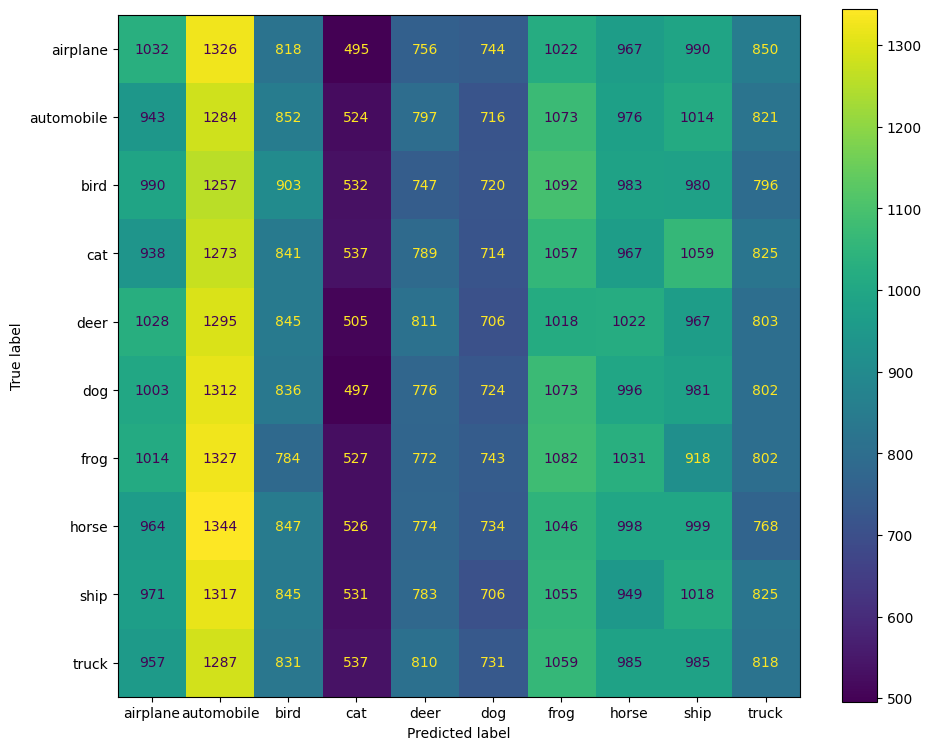

In [124]:
show_confusion_matrix(model24,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


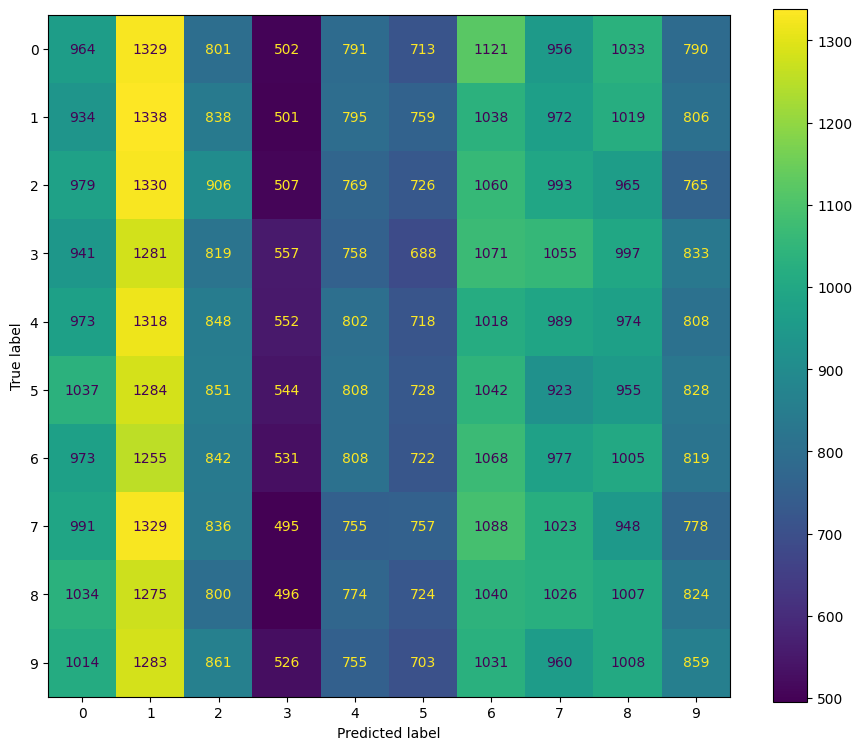

In [125]:
show_confusion_matrix_without_names(model24,test_ds,num_classes)

# Architektura trzeciego modelu

In [126]:
model34 = create_model3(num_classes)

model34.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [127]:
history = model34.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 149s 26ms/step - loss: 1.6751 - categorical_accuracy: 0.3709 - auc: 0.8312 - precision: 0.6226 - recall: 0.1349 - f1_score: 0.4173 - val_loss: 1.4466 - val_categorical_accuracy: 0.4640 - val_auc: 0.8793 - val_precision: 0.6563 - val_recall: 0.2684 - val_f1_score: 0.3243
Epoch 2/20
5625/5625 [==============================] - 146s 26ms/step - loss: 1.4159 - categorical_accuracy: 0.4773 - auc: 0.8846 - precision: 0.6762 - recall: 0.2729 - f1_score: 0.3514 - val_loss: 1.3650 - val_categorical_accuracy: 0.5007 - val_auc: 0.8939 - val_precision: 0.6557 - val_recall: 0.3409 - val_f1_score: 0.3903
Epoch 3/20
5625/5625 [==============================] - 149s 27ms/step - loss: 1.3158 - categorical_accuracy: 0.5173 - auc: 0.9010 - precision: 0.6995 - recall: 0.3334 - f1_score: 0.4175 - val_loss: 1.3206 - val_categorical_accuracy: 0.5149 - val_auc: 0.9008 - val_precision: 0.6705 - val_recall: 0.3544 - val_f1_score: 0.4149
Epoch 4/20
5625/562

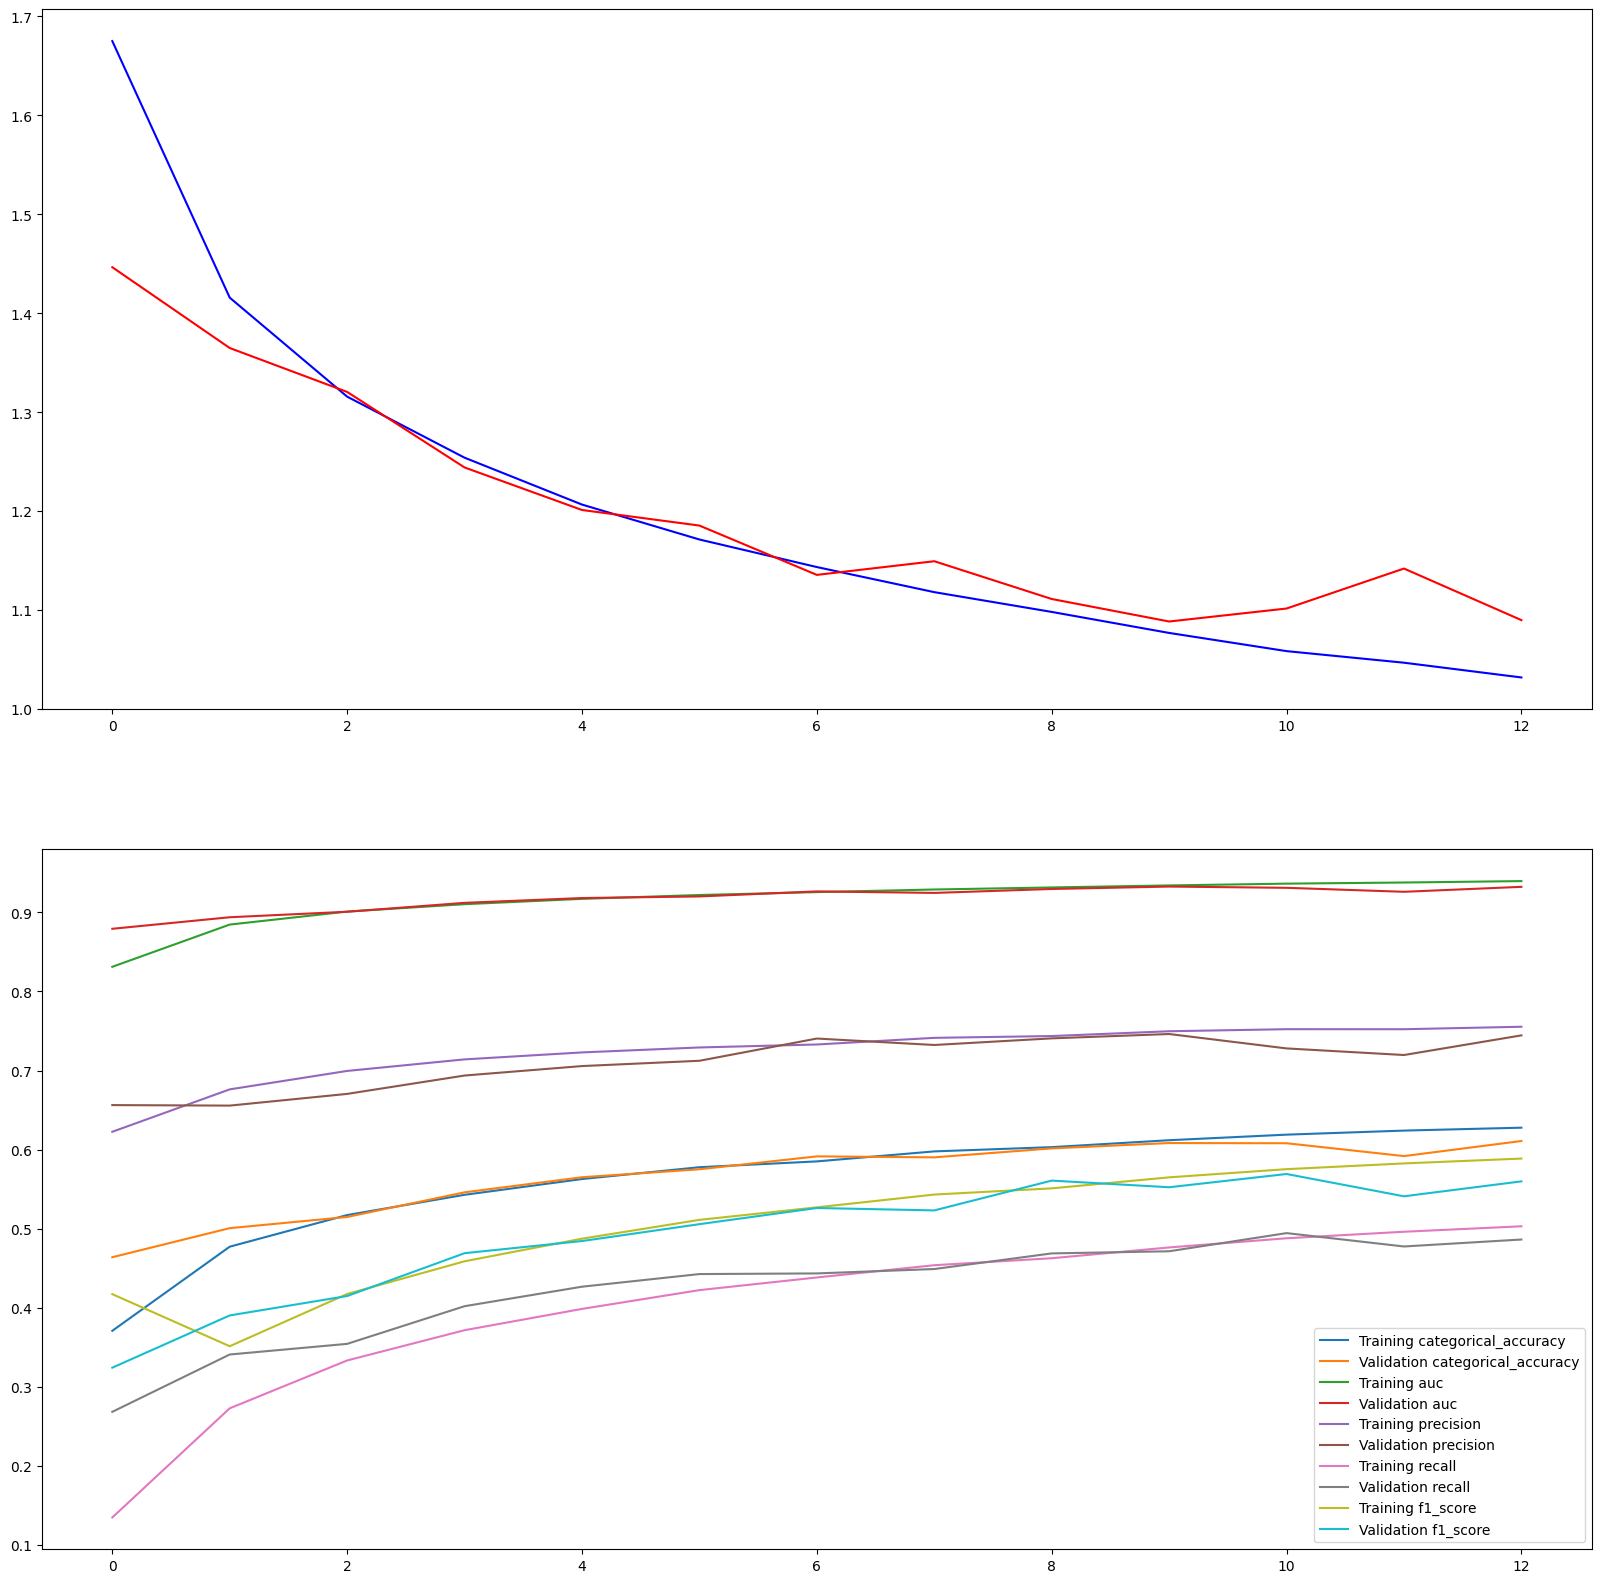

In [128]:
show_training_validation_loss_and_metrics(model34,metrics2)

In [129]:
model34.evaluate(test_it)

5625/5625 [==============================] - 59s 11ms/step - loss: 1.0973 - categorical_accuracy: 0.6076 - auc: 0.9312 - precision: 0.7418 - recall: 0.4837 - f1_score: 0.5578


[1.0972658395767212,
 0.6075999736785889,
 0.9312452077865601,
 0.7417612671852112,
 0.48367777466773987,
 0.5578011274337769]

5625/5625 [==============================] - 17s 3ms/step


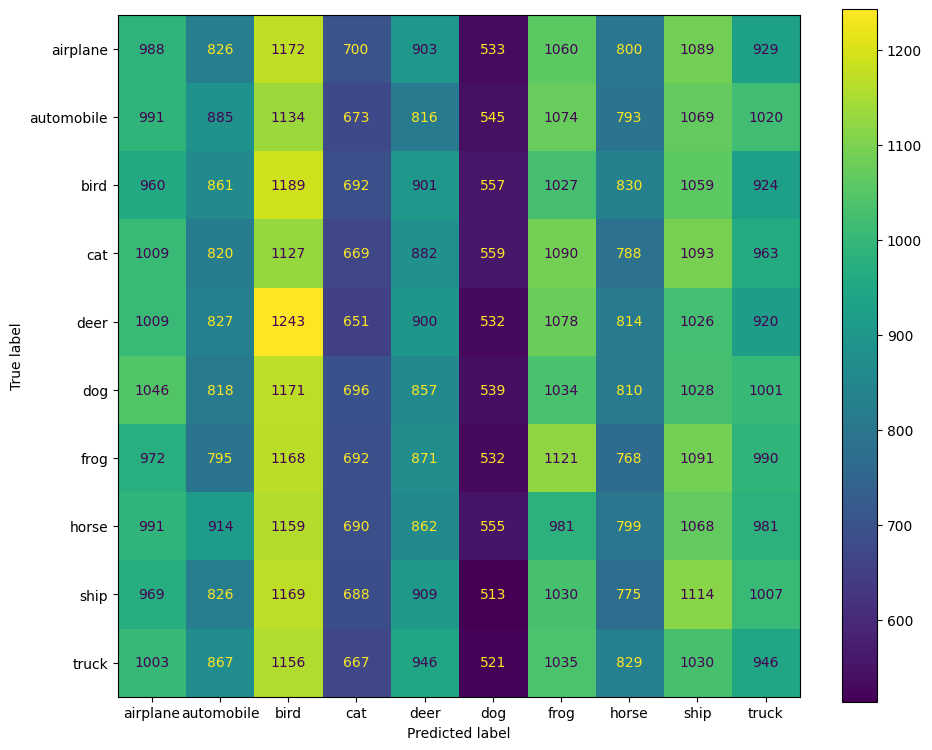

In [130]:
show_confusion_matrix(model34,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


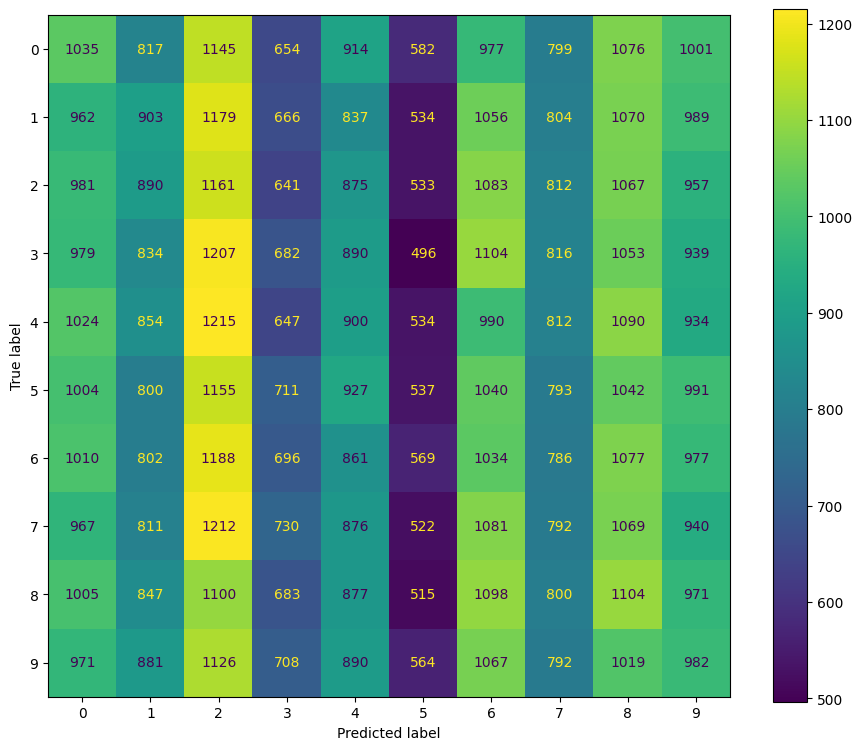

In [131]:
show_confusion_matrix_without_names(model34,test_ds,num_classes)